# ***Social media***
Reddit <- colección masiva de foros, donde la gente puede compartir noticias y contenido, además de comentar las publicaciones de otras personas.

In [ ]:
pip install asyncpraw


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 4.7 MB/s eta 0:00:00


In [ ]:
pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 4.0 MB/s eta 0:00:00


In [ ]:
import praw
import logging
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
import pandas as pd
from datetime import datetime
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Configurar logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

def fetch_comments(submission):
    comments = []
    try:
        submission.comments.replace_more(limit=0)
        comments_list = submission.comments.list()

        if comments_list is None or not hasattr(comments_list, '__iter__'):
            logging.warning(f"No se obtuvieron comentarios o la respuesta no es iterable para la publicación: {submission.title}")
            return comments

        for comment in comments_list:
            comments.append({
                'body': comment.body,
                'created_utc': datetime.utcfromtimestamp(comment.created_utc).year,
                'upvotes': comment.score
            })
        logging.info(f"Comentarios obtenidos de la publicación '{submission.title}': {len(comments)} comentarios.")
    except Exception as e:
        logging.error(f"Error al obtener comentarios para la publicación '{submission.title}': {e}")
    return comments

def generate_wordcloud(text):
    if not text:
        logging.warning("No hay texto para generar la WordCloud.")
        return

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def analyze_term_frequency(comments):
    if not comments:
        logging.warning("No hay comentarios para analizar frecuencia de términos.")
        return None, None

    # Combine all comments into one text
    all_text = " ".join(comment['body'] for comment in comments)

    # Tokenize and clean the text
    tokens = word_tokenize(all_text.lower())
    stop_words = set(stopwords.words('english') + list(string.punctuation))
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]

    # Calculate term frequencies
    term_freq = Counter(filtered_tokens)
    total_terms = sum(term_freq.values())

    # Convert to percentages
    term_percent = {term: (count/total_terms)*100 for term, count in term_freq.most_common(20)}

    return term_freq.most_common(20), term_percent

def analyze_sentiments(comments):
    if not comments:
        logging.warning("No hay comentarios para analizar.")
        return None

    sentiments = {'positive': 0, 'neutral': 0, 'negative': 0}
    for comment in comments:
        analysis = TextBlob(comment['body']).sentiment
        if analysis.polarity > 0.1:
            sentiments['positive'] += 1
        elif analysis.polarity < -0.1:
            sentiments['negative'] += 1
        else:
            sentiments['neutral'] += 1

    total = sum(sentiments.values())
    sentiment_percent = {k: (v/total)*100 for k, v in sentiments.items()}

    logging.info(f"Análisis de sentimientos: {sentiments}")
    logging.info(f"Porcentajes de sentimientos: {sentiment_percent}")
    return sentiments, sentiment_percent

def plot_term_frequency(term_data):
    if not term_data:
        logging.warning("No hay datos de frecuencia de términos para graficar.")
        return

    terms, frequencies = zip(*term_data)

    plt.figure(figsize=(12, 6))
    plt.barh(terms, frequencies, color='skyblue')
    plt.xlabel('Frecuencia')
    plt.ylabel('Término')
    plt.title('20 Términos Más Frecuentes en Comentarios')
    plt.gca().invert_yaxis()
    plt.show()

def plot_sentiment_analysis(sentiments, percentages):
    if not sentiments:
        logging.warning("No hay datos de sentimientos para graficar.")
        return

    labels = list(sentiments.keys())
    sizes = list(sentiments.values())
    colors = ['#ff9999','#66b3ff','#99ff99']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico de barras
    ax1.bar(labels, sizes, color=colors)
    ax1.set_xlabel('Sentimiento')
    ax1.set_ylabel('Número de Comentarios')
    ax1.set_title('Distribución de Sentimientos')

    # Gráfico de pastel
    ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax2.axis('equal')
    ax2.set_title('Porcentaje de Sentimientos')

    plt.tight_layout()
    plt.show()

def plot_comments_by_year(comments):
    if not comments:
        logging.warning("No hay comentarios para graficar por año.")
        return

    df = pd.DataFrame(comments)
    yearly_counts = df['created_utc'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    bars = plt.bar(yearly_counts.index, yearly_counts.values, color='skyblue')

    # Add exact counts on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}',
                 ha='center', va='bottom')

    plt.xlabel('Año')
    plt.ylabel('Número de Comentarios')
    plt.xticks(yearly_counts.index, rotation=45)
    plt.title('Distribución Temporal de Comentarios')
    plt.show()

def analyze_engagement(comments):
    if not comments:
        logging.warning("No hay comentarios para analizar engagement.")
        return None, None

    upvotes = [comment['upvotes'] for comment in comments]
    avg_upvotes = sum(upvotes) / len(upvotes)
    engagement_rate = (sum(1 for vote in upvotes if vote > 0) / len(upvotes)) * 100

    return avg_upvotes, engagement_rate

def main():
    logging.info("Iniciando el script para obtener publicaciones y comentarios")

    # Conectar a Reddit
    reddit = praw.Reddit(
        client_id='B6uafLL8_mKqxaqhLYiw-w',
        client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
        user_agent='Carrot_analysis'
    )
    logging.info("Conectado a Reddit exitosamente")

    subreddit = reddit.subreddit("cooking")
    logging.info(f"Accediendo al subreddit: {subreddit.display_name}")

    publicaciones_procesadas = 0
    all_comments = []

    for submission in subreddit.search("carrot",'nutricosmetic', "nutraceutical","biocosmetic","food waste", 'biofunctional', 'compound',"supply chain", sort="relevance", limit=10):
        publicaciones_procesadas += 1
        logging.info(f"Procesando publicación {publicaciones_procesadas}: {submission.title}")

        # Obtener comentarios de la publicación
        comments = fetch_comments(submission)
        all_comments.extend(comments)

    # Verificar los años extraídos
    years = [comment['created_utc'] for comment in all_comments]
    print(f"Años extraídos: {years}")

    # Unir todos los comentarios en un solo texto
    text = " ".join(comment['body'] for comment in all_comments)

    if text:
        logging.info("Generando WordCloud...")
        generate_wordcloud(text)
    else:
        logging.info("No se encontraron comentarios para generar la WordCloud.")

    # Análisis de frecuencia de términos
    term_freq, term_percent = analyze_term_frequency(all_comments)
    if term_freq:
        print("\nTérminos más frecuentes y sus porcentajes:")
        for term, freq in term_freq:
            print(f"{term}: {freq} apariciones ({term_percent[term]:.2f}%)")
        plot_term_frequency(term_freq)

    # Realizar análisis de sentimientos
    sentiments, sentiment_percent = analyze_sentiments(all_comments)
    if sentiments:
        print("\nDistribución de sentimientos:")
        for sentiment, count in sentiments.items():
            print(f"{sentiment}: {count} comentarios ({sentiment_percent[sentiment]:.1f}%)")
        plot_sentiment_analysis(sentiments, sentiment_percent)

    # Graficar el número de comentarios por año
    plot_comments_by_year(all_comments)

    # Análisis de engagement
    avg_upvotes, engagement_rate = analyze_engagement(all_comments)
    if avg_upvotes is not None:
        print(f"\nMétricas de Engagement:")
        print(f"Promedio de upvotes por comentario: {avg_upvotes:.1f}")
        print(f"Porcentaje de comentarios con upvotes: {engagement_rate:.1f}%")

    logging.info("Script finalizado correctamente")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-1854561182.py:190: DeprecationWarning: Positional arguments for 'Subreddit.search' will no longer be supported in PRAW 8.
Call this function with 'sort', 'syntax', and 'time_filter' as keyword arguments.
  for submission in subreddit.search("carrot",'nutricosmetic', "nutraceutical","biocosmetic","food waste", 'biofunctional', 'compound',"supply chain", sort="relevance", limit=10):


TypeError: praw.models.reddit.subreddit.Subreddit.search() got multiple values for keyword argument 'sort'

In [ ]:
from textblob import TextBlob
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import asyncpraw
import asyncio
import praw
import logging
from wordcloud import WordCloud

In [ ]:
reddit = praw.Reddit(
    client_id='B6uafLL8_mKqxaqhLYiw-w',
    client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
    user_agent='Carrot_analysis'
)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pycountry

# Ejemplo: df_videos ya cargado
# df_videos['country'] = ['AT','MX','IN','IT','HU','ET','FR','SE']

# Reemplazar códigos de país por nombres usando pycountry
def get_country_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return code

paises = df_videos['country'].loc[df_videos['country'] != 'No disponible']
paises = paises.apply(get_country_name)

# Conteo de videos por país
paises_count = paises.value_counts()

# Leer mapa mundial
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Unir conteo al GeoDataFrame
world = world.merge(paises_count.rename("count"), how="left", left_on="name", right_index=True)

# Crear figura
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

# Graficar mapa base en gris claro
world.plot(ax=ax, color='lightgray', edgecolor='black')

# Resaltar países con conteo en un gradiente
world.dropna(subset=['count']).plot(
    ax=ax,
    column='count',
    cmap='OrRd',
    legend=True,
    legend_kwds={'label': "Número de videos", 'orientation': "vertical"}
)

# Título
plt.title('Países con mayor presencia de comentarios', fontsize=16)

plt.show()


ModuleNotFoundError: No module named 'pycountry'

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l


📊 INFORME DE BRECHAS EN LA CADENA DE VALOR DE ZANAHORIAS

📈 ESTADÍSTICAS:
   • Publicaciones analizadas: 77
   • Comentarios recolectados: 972
   • Sentimiento promedio: 0.11

🔍 ANÁLISIS DE BRECHAS (menciones):
   • market: 110 menciones
   • infrastructure: 50 menciones
   • quality: 27 menciones
   • processing: 19 menciones
   • transportation: 10 menciones
   • storage: 5 menciones

🏆 TOP 3 SUBREDDITS:
   • r/environment: 12 posts
   • r/gardening: 11 posts
   • r/homestead: 11 posts

💡 ESTRATEGIAS MÁS EFECTIVAS:
   • Direct Search: 3 posts
   • General Food Waste: 28 posts
   • Solutions: 46 posts

🌐 GENERANDO WORDCLOUD...


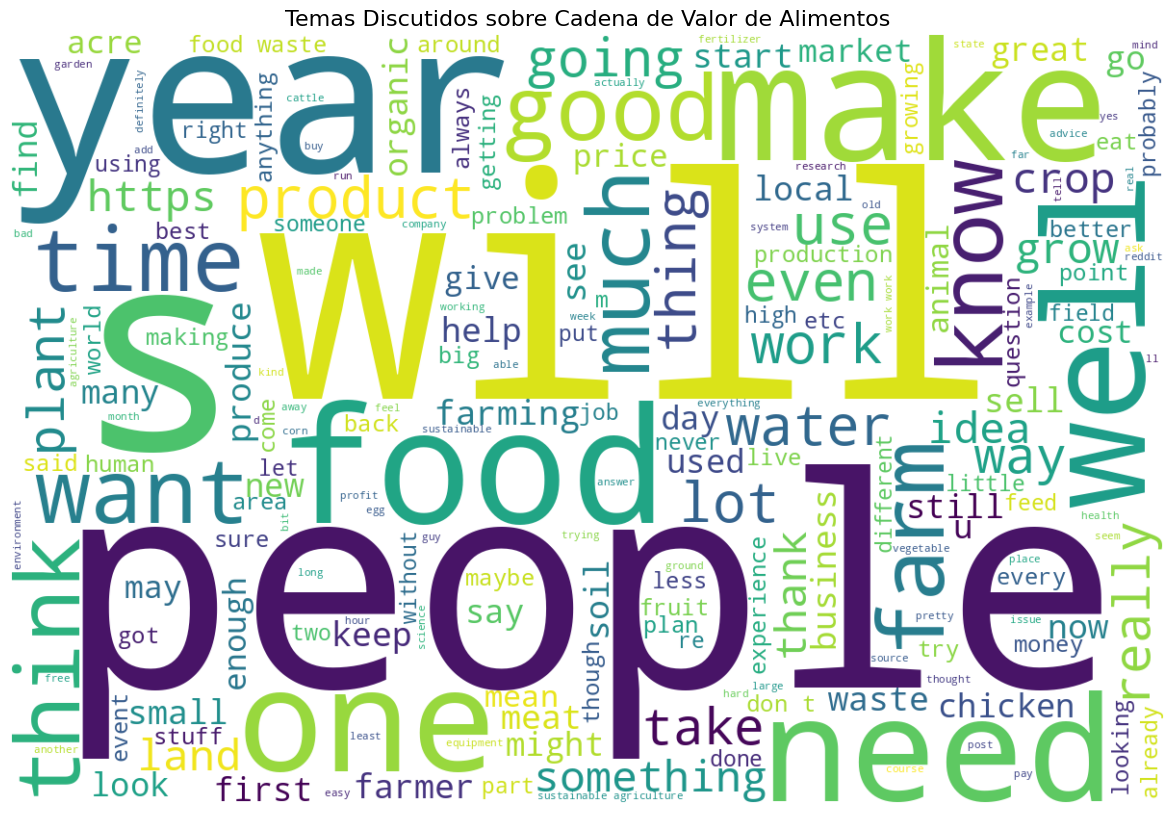


🎯 RECOMENDACIONES ESTRATÉGICAS:
   • Optimizar logística y transporte de productos perecederos
   • Desarrollar productos de valor agregado para reducir pérdidas

📋 PUBLICACIONES RELEVANTES:
1. A state of emergency has been declared in Florida as the wor... (r/environment)
   ↑ 2726 votes - 146 comments
   https://reddit.com/r/environment/comments/97u2tm/a_state_of_emergency_has_been_declared_in_florida/

2. First time gardener... (r/gardening)
   ↑ 584 votes - 39 comments
   https://reddit.com/r/gardening/comments/pipj8d/first_time_gardener/

3. Methane big part of 'alarming' rise in planet-warming gases.... (r/environment)
   ↑ 489 votes - 41 comments
   https://reddit.com/r/environment/comments/12ftrcg/methane_big_part_of_alarming_rise_in/



In [ ]:
import praw
import logging
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from textblob import TextBlob
import re

# Configurar logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Suprimir warnings de PRAW para entornos asíncronos
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="praw")

def fetch_comments(submission):
    """Obtener comentarios de una publicación de Reddit"""
    comments = []
    try:
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            if hasattr(comment, 'body') and comment.body not in ['[deleted]', '[removed]']:
                comments.append(comment.body)
    except Exception as e:
        logging.error(f"Error obteniendo comentarios: {e}")
    return comments

def analyze_sentiment(text):
    """Analizar sentimiento del texto"""
    try:
        blob = TextBlob(text)
        return blob.sentiment.polarity
    except:
        return 0

def search_reddit_content(reddit, query, subreddits, limit_per_sub=5):
    """Buscar contenido en múltiples subreddits"""
    all_content = []

    for subreddit_name in subreddits:
        try:
            logging.info(f"Buscando en r/{subreddit_name}: {query}")
            subreddit = reddit.subreddit(subreddit_name)

            for submission in subreddit.search(
                query=query,
                sort="relevance",
                limit=limit_per_sub,
                time_filter="all"
            ):
                # Evitar rate limiting
                time.sleep(1)

                content = {
                    'id': submission.id,
                    'title': submission.title,
                    'subreddit': subreddit_name,
                    'url': f"https://reddit.com{submission.permalink}",
                    'score': submission.score,
                    'comments_count': submission.num_comments,
                    'created_utc': submission.created_utc,
                    'text': submission.selftext,
                    'comments': fetch_comments(submission)
                }

                full_text = f"{submission.title} {submission.selftext} {' '.join(content['comments'])}"
                content['sentiment'] = analyze_sentiment(full_text)
                content['word_count'] = len(full_text.split())

                all_content.append(content)
                logging.info(f"✓ Encontrado: {submission.title[:50]}...")

        except Exception as e:
            logging.error(f"Error en r/{subreddit_name}: {e}")
            continue

    return all_content

def analyze_carrot_value_chain(reddit):
    """Análisis estratégico de la cadena de valor de zanahorias"""

    # Subreddits para búsqueda ampliada
    subreddits = [
        "agriculture", "farming", "gardening", "homestead",
        "foodscience", "nutrition", "supplychain", "logistics",
        "sustainability", "environment", "foodwaste",
        "business", "economics", "entrepreneur"
    ]

    # Estrategia de búsqueda por capas
    search_strategy = [
        # Búsqueda directa
        {
            'name': 'Direct Search',
            'queries': [
                '"carrot waste" OR "carrot loss"',
                '"carrot supply chain"',
                '"postharvest carrot"',
                '"carrot processing"',
                '"carrot distribution"'
            ]
        },
        # Búsqueda indirecta - problemas generales
        {
            'name': 'General Food Waste',
            'queries': [
                '"vegetable waste" OR "produce loss"',
                '"food supply chain problems"',
                '"postharvest losses"',
                '"agricultural waste"'
            ]
        },
        # Búsqueda de soluciones
        {
            'name': 'Solutions',
            'queries': [
                '"food waste reduction"',
                '"sustainable agriculture"',
                '"value-added products"',
                '"circular economy food"'
            ]
        }
    ]

    all_results = []

    for strategy in search_strategy:
        logging.info(f"\n🔍 ESTRATEGIA: {strategy['name']}")

        for query in strategy['queries']:
            results = search_reddit_content(reddit, query, subreddits, limit_per_sub=3)
            for result in results:
                result['search_strategy'] = strategy['name']
                result['search_query'] = query
            all_results.extend(results)
            time.sleep(2)  # Pausa entre búsquedas

    return all_results

def generate_insights_report(results):
    """Generar reporte de insights"""
    if not results:
        logging.warning("No se encontraron resultados")
        return None

    df = pd.DataFrame(results)

    # Análisis básico
    total_posts = len(df)
    total_comments = sum(len(post['comments']) for post in results)
    avg_sentiment = df['sentiment'].mean()

    # Palabras clave relacionadas con brechas
    gap_keywords = {
        'transportation': ['transport', 'shipping', 'delivery', 'logistics'],
        'storage': ['storage', 'cold storage', 'refrigeration', 'shelf life'],
        'processing': ['processing', 'packaging', 'grading', 'sorting'],
        'market': ['market', 'demand', 'price', 'buyer'],
        'quality': ['quality', 'freshness', 'spoilage', 'rot'],
        'infrastructure': ['infrastructure', 'facilities', 'equipment']
    }

    # Contar menciones de problemas
    gap_analysis = {}
    full_text = ' '.join([f"{post['title']} {post['text']} {' '.join(post['comments'])}" for post in results]).lower()

    for category, keywords in gap_keywords.items():
        count = 0
        for keyword in keywords:
            count += len(re.findall(r'\b' + re.escape(keyword) + r'\b', full_text))
        gap_analysis[category] = count

    # Generar reporte
    report = {
        'summary': {
            'total_posts': total_posts,
            'total_comments': total_comments,
            'avg_sentiment': avg_sentiment,
            'total_words': sum(post['word_count'] for post in results)
        },
        'gap_analysis': gap_analysis,
        'top_posts': sorted(results, key=lambda x: x['score'], reverse=True)[:5],
        'by_subreddit': df.groupby('subreddit').size().to_dict(),
        'by_strategy': df.groupby('search_strategy').size().to_dict()
    }

    return report, full_text

def main():
    logging.info("🚀 Iniciando análisis estratégico de cadena de valor de zanahorias")

    # Conectar a Reddit
    reddit = praw.Reddit(
        client_id='B6uafLL8_mKqxaqhLYiw-w',
        client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
        user_agent='Carrot_analysis/1.0'
    )

    # Realizar análisis
    results = analyze_carrot_value_chain(reddit)
    report, full_text = generate_insights_report(results)

    if not report:
        logging.error("No se pudo generar el reporte. No hay datos suficientes.")
        return

    # Mostrar resultados
    print("\n" + "="*80)
    print("📊 INFORME DE BRECHAS EN LA CADENA DE VALOR DE ZANAHORIAS")
    print("="*80)

    print(f"\n📈 ESTADÍSTICAS:")
    print(f"   • Publicaciones analizadas: {report['summary']['total_posts']}")
    print(f"   • Comentarios recolectados: {report['summary']['total_comments']}")
    print(f"   • Sentimiento promedio: {report['summary']['avg_sentiment']:.2f}")

    print(f"\n🔍 ANÁLISIS DE BRECHAS (menciones):")
    for category, count in sorted(report['gap_analysis'].items(), key=lambda x: x[1], reverse=True):
        if count > 0:
            print(f"   • {category}: {count} menciones")

    print(f"\n🏆 TOP 3 SUBREDDITS:")
    for subreddit, count in sorted(report['by_subreddit'].items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"   • r/{subreddit}: {count} posts")

    print(f"\n💡 ESTRATEGIAS MÁS EFECTIVAS:")
    for strategy, count in report['by_strategy'].items():
        print(f"   • {strategy}: {count} posts")

    # Generar WordCloud si hay suficiente contenido
    if report['summary']['total_words'] > 500:
        print(f"\n🌐 GENERANDO WORDCLOUD...")
        wordcloud = WordCloud(width=1200, height=800, background_color='white').generate(full_text)
        plt.figure(figsize=(15, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Temas Discutidos sobre Cadena de Valor de Alimentos', fontsize=16)
        plt.show()
    else:
        print(f"\n⚠️  Contenido insuficiente para WordCloud ({report['summary']['total_words']} palabras)")

    # Recomendaciones basadas en findings
    print(f"\n🎯 RECOMENDACIONES ESTRATÉGICAS:")
    if report['gap_analysis']['storage'] > 5:
        print("   • Investigar tecnologías de almacenamiento y conservación")
    if report['gap_analysis']['transportation'] > 5:
        print("   • Optimizar logística y transporte de productos perecederos")
    if report['gap_analysis']['processing'] > 3:
        print("   • Desarrollar productos de valor agregado para reducir pérdidas")

    print(f"\n📋 PUBLICACIONES RELEVANTES:")
    for i, post in enumerate(report['top_posts'][:3], 1):
        print(f"{i}. {post['title'][:60]}... (r/{post['subreddit']})")
        print(f"   ↑ {post['score']} votes - {post['comments_count']} comments")
        print(f"   {post['url']}")
        print()

if __name__ == "__main__":
    main()

In [ ]:
# Corre tu análisis y guarda resultados
reddit = praw.Reddit(
    client_id='B6uafLL8_mKqxaqhLYiw-w',
    client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
    user_agent='Carrot_analysis/1.0'
)

results = analyze_carrot_value_chain(reddit)  # <- ahora sí tendrás 'results'
report, full_text = generate_insights_report(results)


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

In [ ]:
pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 48.9 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd

# URL del zip con los países del mundo (versión 110m, admin_0)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

world = gpd.read_file(url)

# Renombrar columnas si quieres algo similar al anterior world
world = world.rename(columns={
    "ADMIN": "name",
    "ADM0_A3": "iso_a3",
    "CONTINENT": "continent",
    "POP_EST": "pop_est",
    "GDP_MD_EST": "gdp_md_est"
})

# Opcional: quedarte solo con las columnas que te interesan
world = world[["name", "continent", "pop_est", "iso_a3", "geometry"]]


🌍 Países detectados en los comentarios:
         country  count
166  Netherlands      5
171         Oman      5
39        Canada      5
142       Mexico      3
182     Portugal      2
104        India      2
113       Jersey      2
8      Argentina      1
32        Brazil      1
14     Australia      1


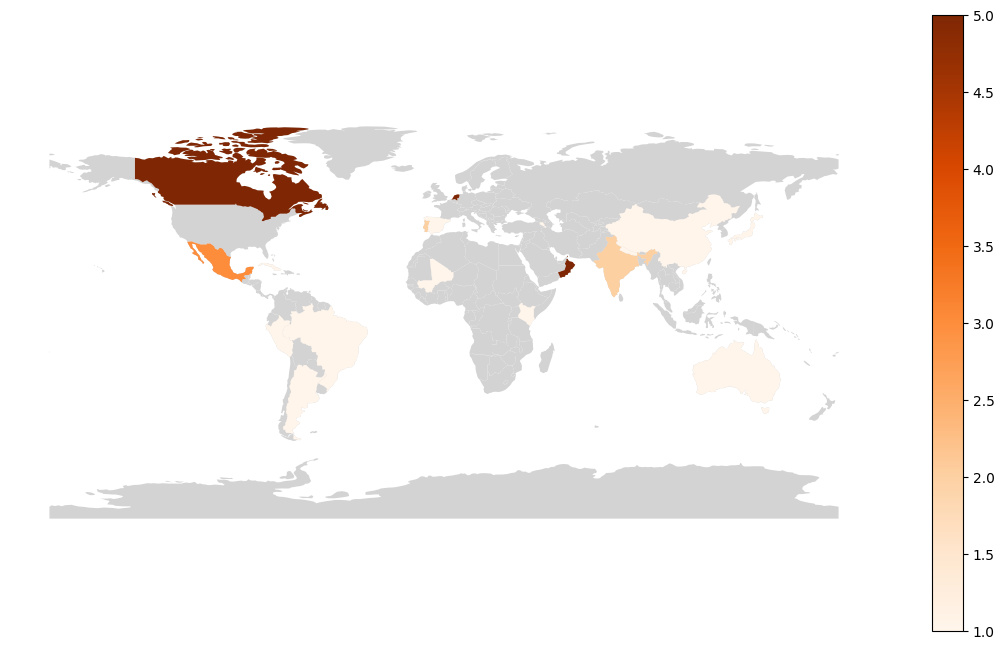

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pycountry

# =====================================================
# 1. Pasar 'results' a DataFrame
# =====================================================
df = pd.DataFrame(results)

# Concatenar título + texto + comentarios en una sola columna
df['full_text'] = df.apply(
    lambda row: f"{row['title']} {row['text']} {' '.join(row['comments'])}", axis=1
)

# =====================================================
# 2. Detectar menciones de países
# =====================================================
countries = {c.name: 0 for c in pycountry.countries}

for text in df['full_text']:
    for country in countries.keys():
        if country.lower() in text.lower():
            countries[country] += 1

# Pasar a DataFrame
df_countries = (
    pd.DataFrame.from_dict(countries, orient='index', columns=['count'])
    .reset_index()
    .rename(columns={'index': 'country'})
)

# Filtrar solo países con menciones > 0
df_countries = df_countries[df_countries['count'] > 0]

print("🌍 Países detectados en los comentarios:")
print(df_countries.sort_values('count', ascending=False).head(10))

# =====================================================
# 3. Leer shapefile del mundo desde Natural Earth
# =====================================================
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

# Renombrar para que tenga columna 'name'
world = world.rename(columns={"ADMIN": "name"})
world = world[["name", "geometry"]]

# =====================================================
# 4. Unir con tus datos de países
# =====================================================
world = world.merge(df_countries, how="left", left_on="name", right_on="country")
world['count'] = world['count'].fillna(0)

# =====================================================
# 5. Graficar mapa
# =====================================================
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
world.plot(ax=ax, color="lightgray")
world[world["count"] > 0].plot(ax=ax, column="count", cmap="Oranges", legend=True)

plt.axis("off")
plt.show()


/tmp/ipython-input-21168325.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_time = df.groupby(pd.Grouper(key='date', freq='M')).agg({


📈 Resumen temporal:
        date  posts  comments
0 2011-01-31      1         3
1 2011-02-28      0         0
2 2011-03-31      0         0
3 2011-04-30      0         0
4 2011-05-31      1         1


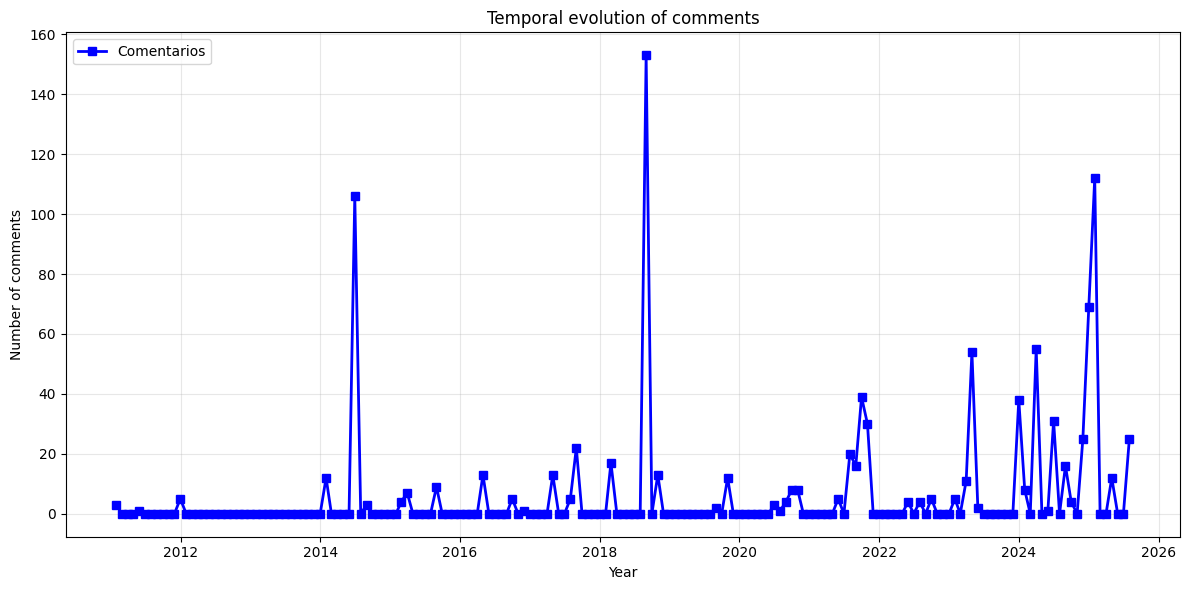

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# =====================================================
# 1. Pasar 'results' a DataFrame
# =====================================================
df = pd.DataFrame(results)

# Convertir timestamp (created_utc) a fecha
df['date'] = pd.to_datetime(df['created_utc'], unit='s')

# Agrupar por mes (puedes cambiar a 'W' = semana, 'Y' = año)
df_time = df.groupby(pd.Grouper(key='date', freq='M')).agg({
    'id': 'count',
    'comments_count': 'sum'
}).reset_index()

df_time.rename(columns={'id': 'posts', 'comments_count': 'comments'}, inplace=True)

print("📈 Resumen temporal:")
print(df_time.head())

# =====================================================
# 2. Graficar evolución de comentarios
# =====================================================
plt.figure(figsize=(12, 6))

# Gráfico de comentarios
plt.plot(df_time['date'], df_time['comments'], marker='s', color='blue', linewidth=2, label='Comentarios')
plt.xlabel("Year")
plt.ylabel("Number of comments")
plt.legend(loc="upper left")
plt.title("Temporal evolution of comments")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

📊 ANÁLISIS DE SENTIMIENTOS GENERAL

📈 Estadísticas del sentimiento:
count    77.000000
mean      0.112288
std       0.142829
min      -0.200000
25%       0.041865
50%       0.116450
75%       0.161726
max       0.750000
Name: sentiment, dtype: float64

🎯 Distribución de sentimientos:
Positivo: 46 posts (59.7%)
Neutral: 27 posts (35.1%)
Negativo: 4 posts (5.2%)


/tmp/ipython-input-1618316191.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sentiment_category', y='sentiment', ax=axes[1, 0], palette=colors)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128078 (\N{THUMBS DOWN SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


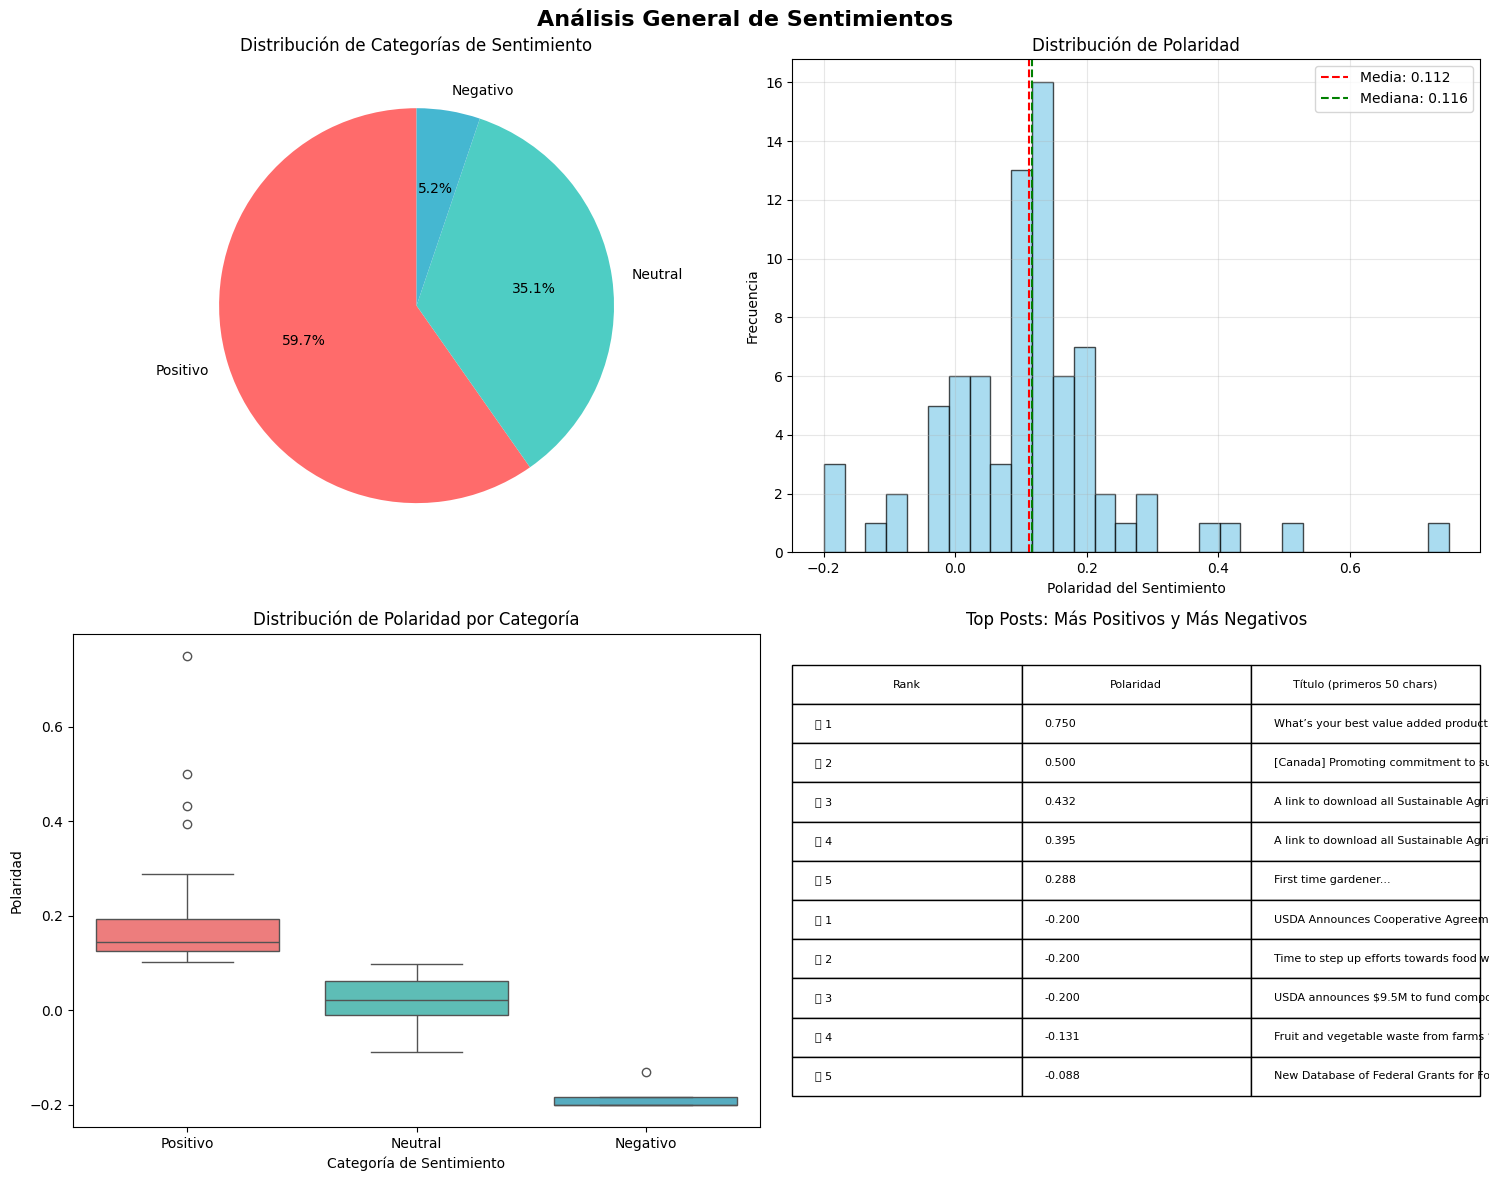


📋 Métricas Adicionales:
📊 Rango de polaridad: -0.200 a 0.750
📈 Desviación estándar: 0.143
🔢 Total de posts analizados: 77
🌟 Posts muy positivos (>0.5): 1 (1.3%)
💥 Posts muy negativos (<-0.5): 0 (0.0%)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# =====================================================
# 1. Pasar 'results' a DataFrame
# =====================================================
df = pd.DataFrame(results)

# =====================================================
# 2. Análisis de sentimientos general
# =====================================================
print("📊 ANÁLISIS DE SENTIMIENTOS GENERAL")
print("=" * 40)

# Estadísticas básicas del sentimiento
sentiment_stats = df['sentiment'].describe()
print("\n📈 Estadísticas del sentimiento:")
print(sentiment_stats)

# Clasificación de sentimientos
def clasificar_sentimiento(polarity):
    if polarity > 0.1:
        return 'Positivo'
    elif polarity < -0.1:
        return 'Negativo'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment'].apply(clasificar_sentimiento)

# Conteo por categoría
sentiment_counts = df['sentiment_category'].value_counts()
sentiment_percent = df['sentiment_category'].value_counts(normalize=True) * 100

print("\n🎯 Distribución de sentimientos:")
for categoria, count, percent in zip(sentiment_counts.index, sentiment_counts.values, sentiment_percent.values):
    print(f"{categoria}: {count} posts ({percent:.1f}%)")

# =====================================================
# 3. Visualizaciones
# =====================================================
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis General de Sentimientos', fontsize=16, fontweight='bold')

# Gráfico 1: Distribución de categorías de sentimiento
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Rojo, Verde, Azul
axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
               colors=colors, startangle=90)
axes[0, 0].set_title('Distribución de Categorías de Sentimiento')

# Gráfico 2: Histograma de polaridad
axes[0, 1].hist(df['sentiment'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df['sentiment'].mean(), color='red', linestyle='--', label=f'Media: {df["sentiment"].mean():.3f}')
axes[0, 1].axvline(df['sentiment'].median(), color='green', linestyle='--', label=f'Mediana: {df["sentiment"].median():.3f}')
axes[0, 1].set_xlabel('Polaridad del Sentimiento')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribución de Polaridad')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Gráfico 3: Boxplot de sentimiento por categoría
sns.boxplot(data=df, x='sentiment_category', y='sentiment', ax=axes[1, 0], palette=colors)
axes[1, 0].set_title('Distribución de Polaridad por Categoría')
axes[1, 0].set_xlabel('Categoría de Sentimiento')
axes[1, 0].set_ylabel('Polaridad')

# Gráfico 4: Top posts por polaridad (más positivos y más negativos)
top_positive = df.nlargest(5, 'sentiment')[['sentiment', 'title']]
top_negative = df.nsmallest(5, 'sentiment')[['sentiment', 'title']]

axes[1, 1].axis('off')  # Ocultar ejes para la tabla
table_data = []
for i, (idx, row) in enumerate(top_positive.iterrows()):
    table_data.append([f"👍 {i+1}", f"{row['sentiment']:.3f}", row['title'][:50] + "..."])
for i, (idx, row) in enumerate(top_negative.iterrows()):
    table_data.append([f"👎 {i+1}", f"{row['sentiment']:.3f}", row['title'][:50] + "..."])

table = axes[1, 1].table(cellText=table_data,
                        colLabels=['Rank', 'Polaridad', 'Título (primeros 50 chars)'],
                        cellLoc='left', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 2)
axes[1, 1].set_title('Top Posts: Más Positivos y Más Negativos')

plt.tight_layout()
plt.show()

# =====================================================
# 4. Métricas adicionales
# =====================================================
print("\n📋 Métricas Adicionales:")
print(f"📊 Rango de polaridad: {df['sentiment'].min():.3f} a {df['sentiment'].max():.3f}")
print(f"📈 Desviación estándar: {df['sentiment'].std():.3f}")
print(f"🔢 Total de posts analizados: {len(df)}")

# Porcentaje de posts muy positivos/negativos
very_positive = len(df[df['sentiment'] > 0.5])
very_negative = len(df[df['sentiment'] < -0.5])
print(f"🌟 Posts muy positivos (>0.5): {very_positive} ({very_positive/len(df)*100:.1f}%)")
print(f"💥 Posts muy negativos (<-0.5): {very_negative} ({very_negative/len(df)*100:.1f}%)")

📊 GENERAL SENTIMENT ANALYSIS

📈 Sentiment Statistics:
count    77.000000
mean      0.112288
std       0.142829
min      -0.200000
25%       0.041865
50%       0.116450
75%       0.161726
max       0.750000
Name: sentiment, dtype: float64

🎯 Sentiment Distribution:
Positive: 46 posts (59.7%)
Neutral: 27 posts (35.1%)
Negative: 4 posts (5.2%)


/tmp/ipython-input-1996449318.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(data=df, x='sentiment_category', y='sentiment',
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


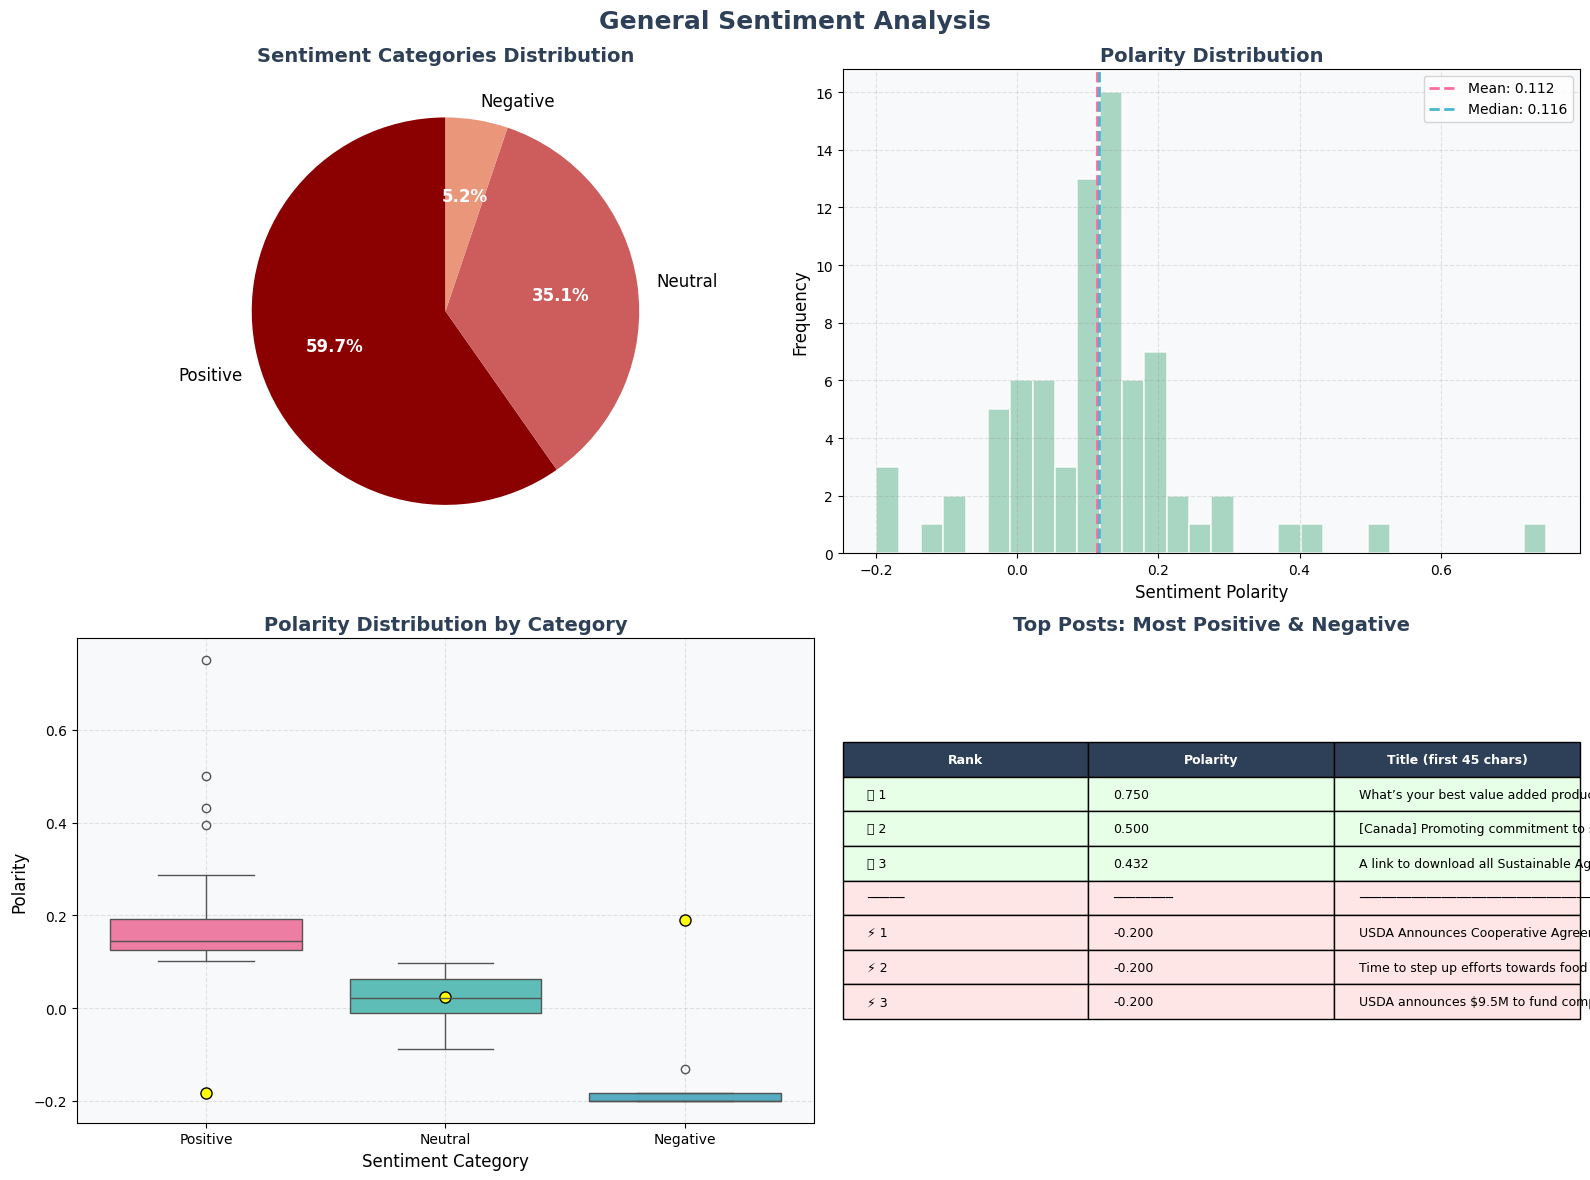


📋 Additional Metrics:
📊 Polarity range: -0.200 to 0.750
📈 Standard deviation: 0.143
🔢 Total posts analyzed: 77
🌟 Very positive posts (>0.5): 1 (1.3%)
💥 Very negative posts (<-0.5): 0 (0.0%)

🎯 Sentiment Score Summary:
   Positive threshold: > 0.1
   Negative threshold: < -0.1
   Neutral range: -0.1 to 0.1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =====================================================
# 1. Convert 'results' to DataFrame
# =====================================================
df = pd.DataFrame(results)

# =====================================================
# 2. General Sentiment Analysis
# =====================================================
print("📊 GENERAL SENTIMENT ANALYSIS")
print("=" * 40)

# Basic sentiment statistics
sentiment_stats = df['sentiment'].describe()
print("\n📈 Sentiment Statistics:")
print(sentiment_stats)

# Sentiment classification
def classify_sentiment(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment'].apply(classify_sentiment)

# Count by category
sentiment_counts = df['sentiment_category'].value_counts()
sentiment_percent = df['sentiment_category'].value_counts(normalize=True) * 100

print("\n🎯 Sentiment Distribution:")
for category, count, percent in zip(sentiment_counts.index, sentiment_counts.values, sentiment_percent.values):
    print(f"{category}: {count} posts ({percent:.1f}%)")

# =====================================================
# 3. Visualizations with beautiful colors
# =====================================================

# Set beautiful color palette
colors = ['#FF6B9D', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
pastel_colors = ['#FFD1DC', '#B5EAD7', '#C7CEEA', '#FFB6C1', '#FFDAC1', '#E2F0CB']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('General Sentiment Analysis', fontsize=18, fontweight='bold', color='#2E4057')

# Plot 1: Sentiment categories distribution (Pie chart)
wedges, texts, autotexts = axes[0, 0].pie(sentiment_counts.values,
                                         labels=sentiment_counts.index,
                                         autopct='%1.1f%%',
                                         colors=['darkred', 'indianred', 'darksalmon'],
                                         startangle=90,
                                         textprops={'fontsize': 12})
axes[0, 0].set_title('Sentiment Categories Distribution', fontsize=14, fontweight='bold', color='#2E4057')

# Make percentages bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Plot 2: Polarity histogram
n, bins, patches = axes[0, 1].hist(df['sentiment'], bins=30, color='#96CEB4',
                                  edgecolor='white', alpha=0.8, linewidth=1.2)
axes[0, 1].axvline(df['sentiment'].mean(), color='#FF6B9D', linestyle='--',
                  linewidth=2, label=f'Mean: {df["sentiment"].mean():.3f}')
axes[0, 1].axvline(df['sentiment'].median(), color='#45B7D1', linestyle='--',
                  linewidth=2, label=f'Median: {df["sentiment"].median():.3f}')
axes[0, 1].set_xlabel('Sentiment Polarity', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Polarity Distribution', fontsize=14, fontweight='bold', color='#2E4057')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.2, color='gray', linestyle='--')
axes[0, 1].set_facecolor('#F8F9FA')

# Plot 3: Boxplot by sentiment category
boxplot = sns.boxplot(data=df, x='sentiment_category', y='sentiment',
                     ax=axes[1, 0], palette=['#FF6B9D', '#4ECDC4', '#45B7D1'])
axes[1, 0].set_title('Polarity Distribution by Category', fontsize=14, fontweight='bold', color='#2E4057')
axes[1, 0].set_xlabel('Sentiment Category', fontsize=12)
axes[1, 0].set_ylabel('Polarity', fontsize=12)
axes[1, 0].set_facecolor('#F8F9FA')
axes[1, 0].grid(alpha=0.2, color='gray', linestyle='--')

# Add mean points to boxplot
means = df.groupby('sentiment_category')['sentiment'].mean()
for i, category in enumerate(means.index):
    axes[1, 0].plot(i, means[category], 'o', color='yellow', markersize=8,
                   markeredgecolor='black', label='Mean' if i == 0 else "")

# Plot 4: Top posts by polarity
top_positive = df.nlargest(3, 'sentiment')[['sentiment', 'title']]
top_negative = df.nsmallest(3, 'sentiment')[['sentiment', 'title']]

axes[1, 1].axis('off')
table_data = []

# Add positive posts
for i, (idx, row) in enumerate(top_positive.iterrows()):
    table_data.append([f"⭐ {i+1}", f"{row['sentiment']:.3f}", row['title'][:45] + "..."])

# Add separator
table_data.append(["─"*5, "─"*8, "─"*50])

# Add negative posts
for i, (idx, row) in enumerate(top_negative.iterrows()):
    table_data.append([f"⚡ {i+1}", f"{row['sentiment']:.3f}", row['title'][:45] + "..."])

table = axes[1, 1].table(cellText=table_data,
                        colLabels=['Rank', 'Polarity', 'Title (first 45 chars)'],
                        cellLoc='left',
                        loc='center',
                        colColours=['#FFEAA7', '#FFEAA7', '#FFEAA7'])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.8)

# Style the table
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#2E4057')
    elif i in [4, 5, 6, 7, 8, 9]:  # Negative posts
        cell.set_facecolor('#FFE6E6')
    elif i in [1, 2, 3]:  # Positive posts
        cell.set_facecolor('#E6FFE6')
    else:  # Separator row
        cell.set_facecolor('#F0F0F0')

axes[1, 1].set_title('Top Posts: Most Positive & Negative', fontsize=14, fontweight='bold', color='#2E4057')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# =====================================================
# 4. Additional Metrics
# =====================================================
print("\n📋 Additional Metrics:")
print(f"📊 Polarity range: {df['sentiment'].min():.3f} to {df['sentiment'].max():.3f}")
print(f"📈 Standard deviation: {df['sentiment'].std():.3f}")
print(f"🔢 Total posts analyzed: {len(df):,}")

# Percentage of very positive/negative posts
very_positive = len(df[df['sentiment'] > 0.5])
very_negative = len(df[df['sentiment'] < -0.5])
print(f"🌟 Very positive posts (>0.5): {very_positive} ({very_positive/len(df)*100:.1f}%)")
print(f"💥 Very negative posts (<-0.5): {very_negative} ({very_negative/len(df)*100:.1f}%)")

# Sentiment score summary
print(f"\n🎯 Sentiment Score Summary:")
print(f"   Positive threshold: > 0.1")
print(f"   Negative threshold: < -0.1")
print(f"   Neutral range: -0.1 to 0.1")

📊 GENERAL SENTIMENT ANALYSIS

📈 Sentiment Statistics:
count    77.000000
mean      0.112288
std       0.142829
min      -0.200000
25%       0.041865
50%       0.116450
75%       0.161726
max       0.750000
Name: sentiment, dtype: float64

🎯 Sentiment Distribution:
Positive: 46 posts (59.7%)
Neutral: 27 posts (35.1%)
Negative: 4 posts (5.2%)


/tmp/ipython-input-465193850.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(data=df, x='sentiment_category', y='sentiment',
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


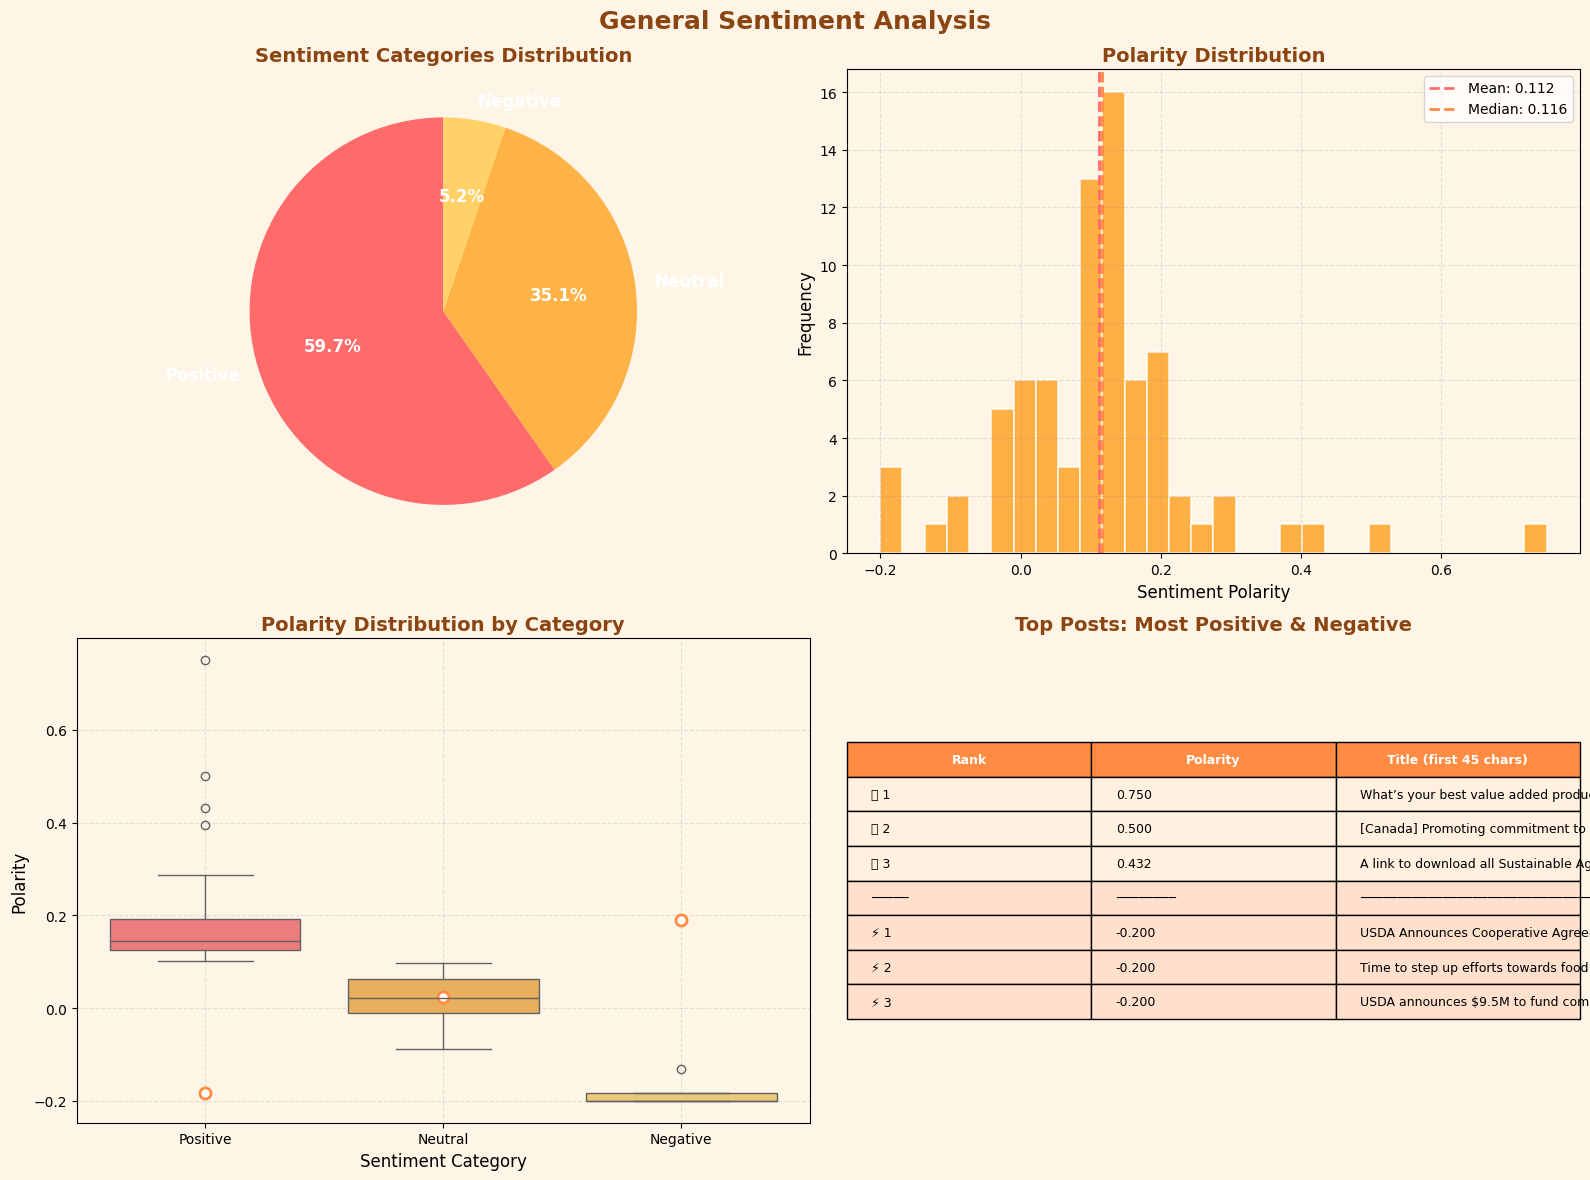


📋 Additional Metrics:
📊 Polarity range: -0.200 to 0.750
📈 Standard deviation: 0.143
🔢 Total posts analyzed: 77
🌟 Very positive posts (>0.5): 1 (1.3%)
💥 Very negative posts (<-0.5): 0 (0.0%)

🎯 Sentiment Score Summary:
   Positive threshold: > 0.1
   Negative threshold: < -0.1
   Neutral range: -0.1 to 0.1

🎨 Color Palette Used:
   Negative: #FF6B6B (Coral)
   Neutral: #FFB347 (Medium Orange)
   Positive: #FFD166 (Light Orange)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =====================================================
# 1. Convert 'results' to DataFrame
# =====================================================
df = pd.DataFrame(results)

# =====================================================
# 2. General Sentiment Analysis
# =====================================================
print("📊 GENERAL SENTIMENT ANALYSIS")
print("=" * 40)

# Basic sentiment statistics
sentiment_stats = df['sentiment'].describe()
print("\n📈 Sentiment Statistics:")
print(sentiment_stats)

# Sentiment classification
def classify_sentiment(polarity):
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['sentiment'].apply(classify_sentiment)

# Count by category
sentiment_counts = df['sentiment_category'].value_counts()
sentiment_percent = df['sentiment_category'].value_counts(normalize=True) * 100

print("\n🎯 Sentiment Distribution:")
for category, count, percent in zip(sentiment_counts.index, sentiment_counts.values, sentiment_percent.values):
    print(f"{category}: {count} posts ({percent:.1f}%)")

# =====================================================
# 3. Visualizations with Orange Color Palette
# =====================================================

# Beautiful orange color palette
orange_palette = {
    'dark_orange': '#FF8C42',    # Vibrant orange
    'medium_orange': '#FFB347',  # Soft orange
    'light_orange': '#FFD166',   # Light golden orange
    'coral': '#FF6B6B',          # Coral orange-red
    'peach': '#FFE0B2',          # Light peach
    'burnt_orange': '#E27D60',   # Burnt orange
    'amber': '#FF9F1C',          # Amber orange
    'apricot': '#FBB98F'         # Apricot
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('General Sentiment Analysis', fontsize=18, fontweight='bold', color='#8B4513')

# Plot 1: Sentiment categories distribution (Pie chart)
category_colors = [orange_palette['coral'], orange_palette['medium_orange'], orange_palette['light_orange']]
wedges, texts, autotexts = axes[0, 0].pie(sentiment_counts.values,
                                         labels=sentiment_counts.index,
                                         autopct='%1.1f%%',
                                         colors=category_colors,
                                         startangle=90,
                                         textprops={'fontsize': 12, 'color': 'white', 'fontweight': 'bold'})
axes[0, 0].set_title('Sentiment Categories Distribution', fontsize=14, fontweight='bold', color='#8B4513')

# Make percentages bold and white
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Plot 2: Polarity histogram
n, bins, patches = axes[0, 1].hist(df['sentiment'], bins=30, color=orange_palette['amber'],
                                  edgecolor='white', alpha=0.8, linewidth=1.2)
axes[0, 1].axvline(df['sentiment'].mean(), color=orange_palette['coral'], linestyle='--',
                  linewidth=2, label=f'Mean: {df["sentiment"].mean():.3f}')
axes[0, 1].axvline(df['sentiment'].median(), color=orange_palette['dark_orange'], linestyle='--',
                  linewidth=2, label=f'Median: {df["sentiment"].median():.3f}')
axes[0, 1].set_xlabel('Sentiment Polarity', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('Polarity Distribution', fontsize=14, fontweight='bold', color='#8B4513')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.2, color='gray', linestyle='--')
axes[0, 1].set_facecolor('#FFF5E6')

# Plot 3: Boxplot by sentiment category
box_colors = [orange_palette['coral'], orange_palette['medium_orange'], orange_palette['light_orange']]
boxplot = sns.boxplot(data=df, x='sentiment_category', y='sentiment',
                     ax=axes[1, 0], palette=box_colors)
axes[1, 0].set_title('Polarity Distribution by Category', fontsize=14, fontweight='bold', color='#8B4513')
axes[1, 0].set_xlabel('Sentiment Category', fontsize=12)
axes[1, 0].set_ylabel('Polarity', fontsize=12)
axes[1, 0].set_facecolor('#FFF5E6')
axes[1, 0].grid(alpha=0.2, color='gray', linestyle='--')

# Add mean points to boxplot
means = df.groupby('sentiment_category')['sentiment'].mean()
for i, category in enumerate(means.index):
    axes[1, 0].plot(i, means[category], 'o', color='white', markersize=8,
                   markeredgecolor=orange_palette['dark_orange'], markeredgewidth=2,
                   label='Mean' if i == 0 else "")

# Plot 4: Top posts by polarity
top_positive = df.nlargest(3, 'sentiment')[['sentiment', 'title']]
top_negative = df.nsmallest(3, 'sentiment')[['sentiment', 'title']]

axes[1, 1].axis('off')
table_data = []

# Add positive posts
for i, (idx, row) in enumerate(top_positive.iterrows()):
    table_data.append([f"⭐ {i+1}", f"{row['sentiment']:.3f}", row['title'][:45] + "..."])

# Add separator
table_data.append(["─"*5, "─"*8, "─"*50])

# Add negative posts
for i, (idx, row) in enumerate(top_negative.iterrows()):
    table_data.append([f"⚡ {i+1}", f"{row['sentiment']:.3f}", row['title'][:45] + "..."])

table = axes[1, 1].table(cellText=table_data,
                        colLabels=['Rank', 'Polarity', 'Title (first 45 chars)'],
                        cellLoc='left',
                        loc='center',
                        colColours=[orange_palette['light_orange']]*3)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.8)

# Style the table with orange tones
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor(orange_palette['dark_orange'])
    elif i in [4, 5, 6, 7, 8, 9]:  # Negative posts
        cell.set_facecolor('#FFE0CC')
    elif i in [1, 2, 3]:  # Positive posts
        cell.set_facecolor('#FFF0E0')
    else:  # Separator row
        cell.set_facecolor('#FFE5CC')

axes[1, 1].set_title('Top Posts: Most Positive & Negative', fontsize=14, fontweight='bold', color='#8B4513')

# Add background color to the figure
fig.patch.set_facecolor('#FFF5E6')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# =====================================================
# 4. Additional Metrics
# =====================================================
print("\n📋 Additional Metrics:")
print(f"📊 Polarity range: {df['sentiment'].min():.3f} to {df['sentiment'].max():.3f}")
print(f"📈 Standard deviation: {df['sentiment'].std():.3f}")
print(f"🔢 Total posts analyzed: {len(df):,}")

# Percentage of very positive/negative posts
very_positive = len(df[df['sentiment'] > 0.5])
very_negative = len(df[df['sentiment'] < -0.5])
print(f"🌟 Very positive posts (>0.5): {very_positive} ({very_positive/len(df)*100:.1f}%)")
print(f"💥 Very negative posts (<-0.5): {very_negative} ({very_negative/len(df)*100:.1f}%)")

# Sentiment score summary
print(f"\n🎯 Sentiment Score Summary:")
print(f"   Positive threshold: > 0.1")
print(f"   Negative threshold: < -0.1")
print(f"   Neutral range: -0.1 to 0.1")

# Print color palette info for reference
print(f"\n🎨 Color Palette Used:")
print(f"   Negative: {orange_palette['coral']} (Coral)")
print(f"   Neutral: {orange_palette['medium_orange']} (Medium Orange)")
print(f"   Positive: {orange_palette['light_orange']} (Light Orange)")


In [ ]:
import praw
import pandas as pd
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import string
import logging

# Configuración inicial para evitar warnings y descargar recursos necesarios
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  # Recurso adicional que podría necesitar TextBlob

# Configurar logging para PRAW
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def setup_reddit_connection():
    """Establece conexión con la API de Reddit"""
    try:
        reddit = praw.Reddit(
            client_id='B6uafLL8_mKqxaqhLYiw-w',
            client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
            user_agent='Carrot_analysis'
        )
        # Verificar conexión
        if not reddit.read_only:
            logger.warning("El cliente de Reddit no está en modo solo lectura")
        return reddit
    except Exception as e:
        logger.error(f"Error al conectar con Reddit: {e}")
        raise

def fetch_comments(subreddit_name, search_term, limit=5):
    """Recolecta comentarios de Reddit con manejo de errores"""
    try:
        reddit = setup_reddit_connection()
        subreddit = reddit.subreddit(subreddit_name)
        all_comments = []

        for submission in subreddit.search(search_term, sort="relevance", limit=limit):
            try:
                submission.comments.replace_more(limit=0)
                for comment in submission.comments.list():
                    all_comments.append({
                        'text': comment.body,
                        'upvotes': comment.score,
                        'created': pd.to_datetime(comment.created_utc, unit='s')
                    })
            except Exception as e:
                logger.warning(f"Error al procesar submission {submission.id}: {e}")
                continue

        return pd.DataFrame(all_comments) if all_comments else pd.DataFrame()

    except Exception as e:
        logger.error(f"Error en fetch_comments: {e}")
        return pd.DataFrame()

def clean_text(text):
    """Limpia y tokeniza el texto con manejo robusto"""
    try:
        if not isinstance(text, str):
            return []

        tokens = word_tokenize(text.lower())
        stop_words = set(stopwords.words('english') + list(string.punctuation))
        return [word for word in tokens if word not in stop_words and word.isalpha()]
    except Exception as e:
        logger.warning(f"Error en clean_text: {e}")
        return []

def calculate_quantitative_metrics(df):
    """Calcula métricas cuantitativas con manejo de errores"""
    if df.empty:
        logger.warning("DataFrame vacío recibido")
        return None

    metrics = {}

    try:
        # 1. Métricas de Términos
        all_words = clean_text(' '.join(df['text'].astype(str)))
        term_freq = Counter(all_words)
        total_terms = sum(term_freq.values()) if term_freq else 1  # Evitar división por cero
        top_terms = term_freq.most_common(20)

        metrics['top_terms'] = [(term, count, (count/total_terms)*100)
                              for term, count in top_terms] if top_terms else []
    except Exception as e:
        logger.error(f"Error calculando métricas de términos: {e}")
        metrics['top_terms'] = []

    try:
        # 2. Métricas de Sentimiento
        df['sentiment'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
        sentiment_counts = {
            'positive': len(df[df['sentiment'] > 0.1]),
            'neutral': len(df[(df['sentiment'] >= -0.1) & (df['sentiment'] <= 0.1)]),
            'negative': len(df[df['sentiment'] < -0.1])
        }
        total_sentiments = sum(sentiment_counts.values()) or 1  # Evitar división por cero

        metrics['sentiment'] = {
            'counts': sentiment_counts,
            'percentages': {k: (v/total_sentiments)*100 for k, v in sentiment_counts.items()}
        }
    except Exception as e:
        logger.error(f"Error calculando métricas de sentimiento: {e}")
        metrics['sentiment'] = {'counts': {}, 'percentages': {}}

    try:
        # 3. Métricas de Engagement
        metrics['engagement'] = {
            'avg_upvotes': df['upvotes'].mean(),
            'engagement_rate': (len(df[df['upvotes'] > 0]) / len(df)) * 100 if len(df) > 0 else 0
        }
    except Exception as e:
        logger.error(f"Error calculando métricas de engagement: {e}")
        metrics['engagement'] = {'avg_upvotes': 0, 'engagement_rate': 0}

    try:
        # 4. Métricas Temporales
        df['year'] = df['created'].dt.year
        yearly_counts = df['year'].value_counts().sort_index()

        metrics['temporal'] = {
            'yearly_counts': yearly_counts.to_dict(),
            'total_comments': len(df)
        }
    except Exception as e:
        logger.error(f"Error calculando métricas temporales: {e}")
        metrics['temporal'] = {'yearly_counts': {}, 'total_comments': 0}

    return metrics

def print_metrics(metrics):
    """Imprime las métricas de forma organizada"""
    if not metrics:
        print("No hay métricas para mostrar")
        return

    print("=== MÉTRICAS CUANTITATIVAS ===")

    # 1. Términos
    if metrics.get('top_terms'):
        print("\n1. Términos más frecuentes:")
        print("{:<20} {:<15} {:<15}".format("Término", "Frecuencia", "Porcentaje"))
        for term, freq, percent in metrics['top_terms']:
            print("{:<20} {:<15} {:<15.2f}%".format(term, freq, percent))
    else:
        print("\n1. No se encontraron términos para analizar")

    # 2. Sentimiento
    if metrics.get('sentiment', {}).get('counts'):
        print("\n2. Análisis de Sentimiento:")
        print("{:<15} {:<15} {:<15}".format("Sentimiento", "Cantidad", "Porcentaje"))
        for sentiment in metrics['sentiment']['counts']:
            count = metrics['sentiment']['counts'][sentiment]
            percent = metrics['sentiment']['percentages'][sentiment]
            print("{:<15} {:<15} {:<15.1f}%".format(sentiment, count, percent))
    else:
        print("\n2. No se pudo analizar el sentimiento")

    # 3. Engagement
    print("\n3. Métricas de Engagement:")
    print("Promedio de upvotes por comentario: {:.2f}".format(
        metrics.get('engagement', {}).get('avg_upvotes', 0)))
    print("Porcentaje de comentarios con upvotes: {:.1f}%".format(
        metrics.get('engagement', {}).get('engagement_rate', 0)))

    # 4. Temporal
    print("\n4. Distribución Temporal:")
    print("Total de comentarios analizados:", metrics.get('temporal', {}).get('total_comments', 0))
    yearly_counts = metrics.get('temporal', {}).get('yearly_counts', {})
    if yearly_counts:
        print("Por año:")
        for year in sorted(yearly_counts):
            print(f"{year}: {yearly_counts[year]} comentarios")
    else:
        print("No hay datos temporales disponibles")

def main():
    try:
        logger.info("Iniciando recolección de datos...")
        df_comments = fetch_comments('nutricosmetic', "nutraceutical","biocosmetic","food waste", 'biofunctional', 'compound',"supply chain","carrot")

        logger.info("Calculando métricas...")
        metrics = calculate_quantitative_metrics(df_comments)

        logger.info("Mostrando resultados...")
        print_metrics(metrics)

    except Exception as e:
        logger.error(f"Error en main: {e}")
    finally:
        logger.info("Proceso completado")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more

=== MÉTRICAS CUANTITATIVAS ===

1. No se encontraron términos para analizar

2. Análisis de Sentimiento:
Sentimiento     Cantidad        Porcentaje     
positive        934             40.0           %
neutral         1127            48.3           %
negative        273             11.7           %

3. Métricas de Engagement:
Promedio de upvotes por comentario: 16.81
Porcentaje de comentarios con upvotes: 96.4%

4. Distribución Temporal:
Total de comentarios analizados: 2334
Por año:
2019: 478 comentarios
2021: 480 comentarios
2022: 448 comentarios
2023: 5 comentarios
2024: 923 comentarios


In [ ]:
pip install geotext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.9 MB/s eta 0:00:00


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

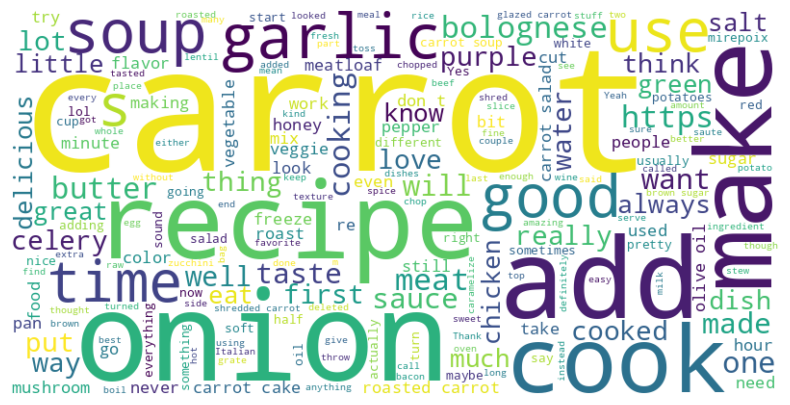

In [ ]:
import praw
import logging
from geotext import GeoText
import folium
from geopy.geocoders import Nominatim
import time
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Configurar logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

# Inicializar el geolocalizador con timeout extendido
geolocator = Nominatim(user_agent="geoapiExercises", timeout=10)

def detectar_pais(comentario):
    lugares = GeoText(comentario)
    if lugares.countries:
        return lugares.countries[0]  # Retorna el primer país detectado
    return 'No country or city mentioned'

def obtener_coordenadas(pais):
    try:
        location = geolocator.geocode(pais)
        if location:
            return location.latitude, location.longitude
    except Exception as e:
        logging.error(f"Error al obtener coordenadas para {pais}: {e}")
        time.sleep(2)  # Espera de 2 segundos antes de intentar de nuevo
    return None

def generar_mapa(paises):
    mapa = folium.Map(location=[0, 0], zoom_start=2)

    for pais in paises:
        coordenadas = obtener_coordenadas(pais)
        if coordenadas:
            folium.Marker(location=coordenadas, popup=pais).add_to(mapa)

    mapa.save("mapa_paises_comentarios.html")
    logging.info("Mapa guardado en 'mapa_paises_comentarios.html'.")

def fetch_comments(submission):
    comments = []
    try:
        submission.comments.replace_more(limit=0)
        comments_list = submission.comments.list()

        logging.debug(f"Estructura de datos de comments_list: {type(comments_list)}")
        logging.debug(f"Contenido de comments_list: {comments_list}")

        if comments_list is None:
            logging.warning(f"No se obtuvieron comentarios (None) para la publicación: {submission.title}")
            return comments

        if not hasattr(comments_list, '__iter__'):
            logging.error(f"La respuesta de comentarios no es iterable para la publicación: {submission.title}")
            return comments

        for comment in comments_list:
            comments.append(comment.body)
        logging.info(f"Comentarios obtenidos de la publicación '{submission.title}': {len(comments)} comentarios.")
    except Exception as e:
        logging.error(f"Error al obtener comentarios para la publicación '{submission.title}': {e}")
    return comments

def generate_wordcloud(text):
    if not text:
        logging.warning("No hay texto para generar la WordCloud.")
        return

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def main():
    logging.info("Iniciando el script para obtener publicaciones y comentarios")

    reddit = praw.Reddit(
        client_id='B6uafLL8_mKqxaqhLYiw-w',
        client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
        user_agent='Carrot_analysis'
    )
    logging.info("Conectado a Reddit exitosamente")

    subreddit = reddit.subreddit("cooking")
    logging.info(f"Accediendo al subreddit: {subreddit.display_name}")

    publicaciones_procesadas = 0
    all_comments = []
    paises_detectados = set()

    for submission in subreddit.search("carrot",'nutricosmetic', "nutraceutical","biocosmetic","food waste", 'biofunctional', 'compound',"supply chain", sort="relevance", limit=5):
        publicaciones_procesadas += 1
        logging.info(f"Procesando publicación {publicaciones_procesadas}: {submission.title}")

        comments = fetch_comments(submission)

        for comment in comments:
            pais_detectado = detectar_pais(comment)
            if pais_detectado != 'No country or city mentioned':
                paises_detectados.add(pais_detectado)
            logging.info(f"Comentario: {comment}")
            logging.info(f"País detectado: {pais_detectado}")

        all_comments.extend(comments)

    if paises_detectados:
        logging.info("Generando mapa con los países detectados...")
        generar_mapa(paises_detectados)
    else:
        logging.info("No se detectaron países para generar el mapa.")

    text = " ".join(all_comments)

    if text:
        logging.info("Generando WordCloud...")
        generate_wordcloud(text)
    else:
        logging.info("No se encontraron comentarios para generar la WordCloud.")

    logging.info("Script finalizado correctamente")

if __name__ == "__main__":
    main()


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Reemplazar los códigos de país con los nombres completos
paises = df_videos['country'].loc[df_videos['country'] != 'No disponible']
paises = paises.replace({
    'AT': 'Austria', 'MX': 'Mexico', 'IN': 'India', 'IT': 'Italy',
    'HU': 'Hungary', 'ET': 'Ethiopia', 'FR': 'France', 'SE': 'Sweden'
})
# Conteo de videos por país
paises_count = paises.value_counts()

# Leer datos del mapa mundial desde geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filtrar los países que están en tus datos
countries_to_highlight = list(paises.unique())
print("Países a resaltar:", countries_to_highlight)

# Verificar nombres de países que no se encontraron en el DataFrame world
missing_countries = [country for country in countries_to_highlight if country not in world['name'].values]
print("Países no encontrados en el DataFrame world:", missing_countries)

world_highlighted = world[world['name'].isin(countries_to_highlight)]

# Crear la figura y los ejes
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Graficar el mapa mundial en gris claro
world.plot(ax=ax, color='lightgray')

# Resaltar los países seleccionados en un color distinto (por ejemplo, naranja)
world_highlighted.plot(ax=ax, color='orange')

# Añadir título y etiquetas
plt.title('Países con mayor presencia de comentarios', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Mostrar el mapa
plt.show()


NameError: name 'df_videos' is not defined

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

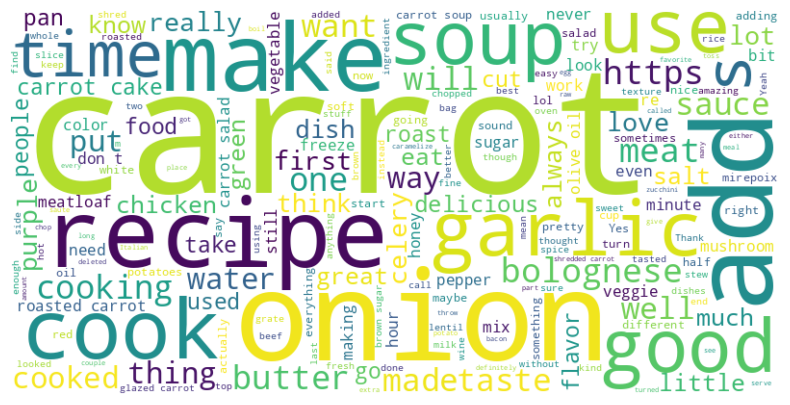

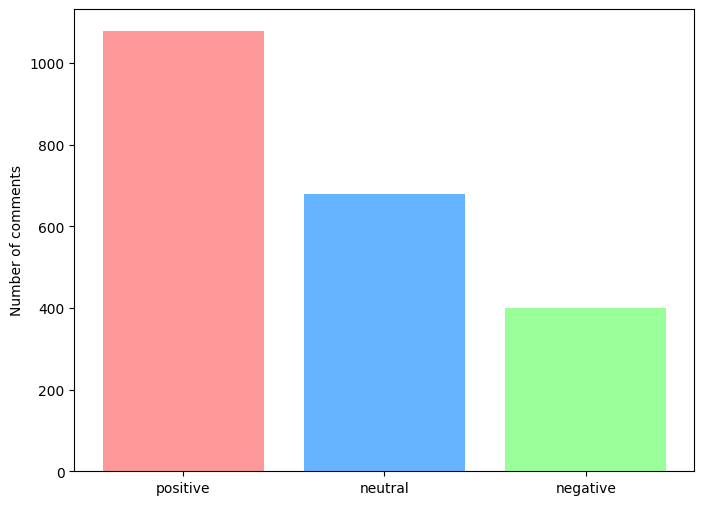

In [ ]:
import praw
import logging
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob

# Configurar logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

def fetch_comments(submission):
    comments = []
    try:
        submission.comments.replace_more(limit=0)  # Eliminar comentarios "continuación"
        comments_list = submission.comments.list()

        logging.debug(f"Estructura de datos de comments_list: {type(comments_list)}")
        logging.debug(f"Contenido de comments_list: {comments_list}")

        if comments_list is None:
            logging.warning(f"No se obtuvieron comentarios (None) para la publicación: {submission.title}")
            return comments  # Devuelve una lista vacía si no hay comentarios

        if not hasattr(comments_list, '__iter__'):
            logging.error(f"La respuesta de comentarios no es iterable para la publicación: {submission.title}")
            return comments

        for comment in comments_list:
            comments.append(comment.body)
        logging.info(f"Comentarios obtenidos de la publicación '{submission.title}': {len(comments)} comentarios.")
    except Exception as e:
        logging.error(f"Error al obtener comentarios para la publicación '{submission.title}': {e}")
    return comments

def generate_wordcloud(text):
    if not text:
        logging.warning("No hay texto para generar la WordCloud.")
        return

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def analyze_sentiments(comments):
    if not comments:
        logging.warning("No hay comentarios para analizar.")
        return

    sentiments = {'positive': 0, 'neutral': 0, 'negative': 0}
    for comment in comments:
        analysis = TextBlob(comment).sentiment
        if analysis.polarity > 0:
            sentiments['positive'] += 1
        elif analysis.polarity == 0:
            sentiments['neutral'] += 1
        else:
            sentiments['negative'] += 1

    logging.info(f"Análisis de sentimientos: {sentiments}")
    return sentiments

def plot_sentiment_analysis(sentiments):
    if not sentiments:
        logging.warning("No hay datos de sentimientos para graficar.")
        return

    labels = list(sentiments.keys())
    sizes = list(sentiments.values())
    colors = ['#ff9999','#66b3ff','#99ff99']

    plt.figure(figsize=(8, 6))
    plt.bar(labels, sizes, color=colors)
    plt.ylabel('Number of comments')
    plt.show()

def main():
    logging.info("Iniciando el script para obtener publicaciones y comentarios")

    # Conectar a Reddit
    reddit = praw.Reddit(
        client_id='B6uafLL8_mKqxaqhLYiw-w',
        client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
        user_agent='Carrot_analysis'
    )
    logging.info("Conectado a Reddit exitosamente")

    subreddit = reddit.subreddit("cooking")
    logging.info(f"Accediendo al subreddit: {subreddit.display_name}")

    publicaciones_procesadas = 0
    all_comments = []

    for submission in subreddit.search("carrot",'nutricosmetic', "nutraceutical","biocosmetic","food waste", 'biofunctional', 'compound',"supply chain", sort="relevance", limit=5):
        publicaciones_procesadas += 1
        logging.info(f"Procesando publicación {publicaciones_procesadas}: {submission.title}")

        # Obtener comentarios de la publicación
        comments = fetch_comments(submission)
        all_comments.extend(comments)  # Añadir todos los comentarios obtenidos a la lista general

    # Unir todos los comentarios en un solo texto
    text = " ".join(all_comments)

    if text:
        logging.info("Generando WordCloud...")
        generate_wordcloud(text)
    else:
        logging.info("No se encontraron comentarios para generar la WordCloud.")

    # Realizar análisis de sentimientos
    sentiments = analyze_sentiments(all_comments)

    # Graficar el análisis de sentimientos
    plot_sentiment_analysis(sentiments)

    logging.info("Script finalizado correctamente")

if __name__ == "__main__":
    main()



It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Años extraídos: [2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024,

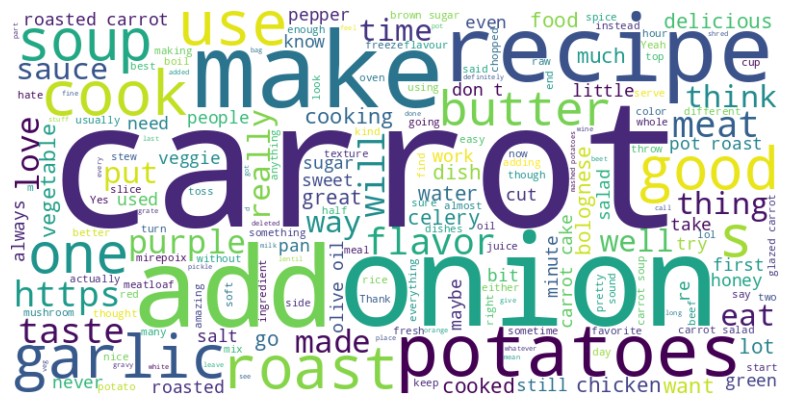

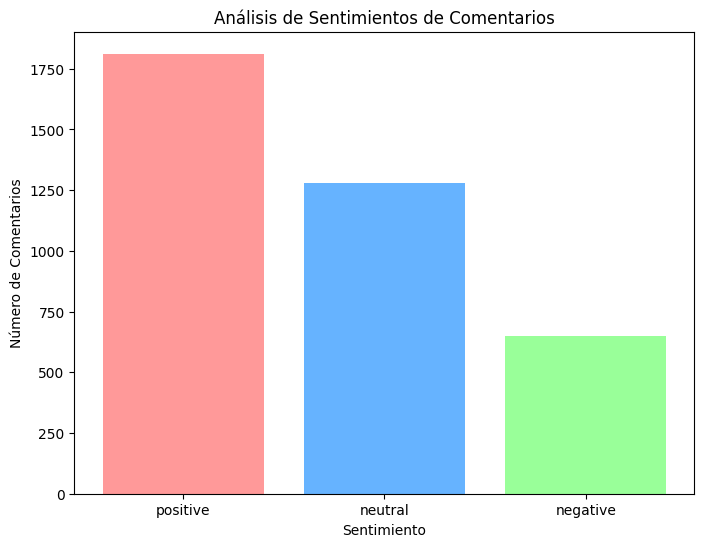

Datos de los comentarios:
                                                body  created_utc
0  Carrots soften more in the dish after you add ...         2024
1  I get annoyed at recipes that have you add the...         2024
2  You can cook onions for about two hours. I don...         2024
3  Carrots have more immediately accessible sugar...         2024
4  It's not aways just about cooking times and so...         2024
Conteo de comentarios por año:
created_utc
2019     479
2021     821
2022     452
2023       5
2024    1961
2025      23
Name: count, dtype: int64


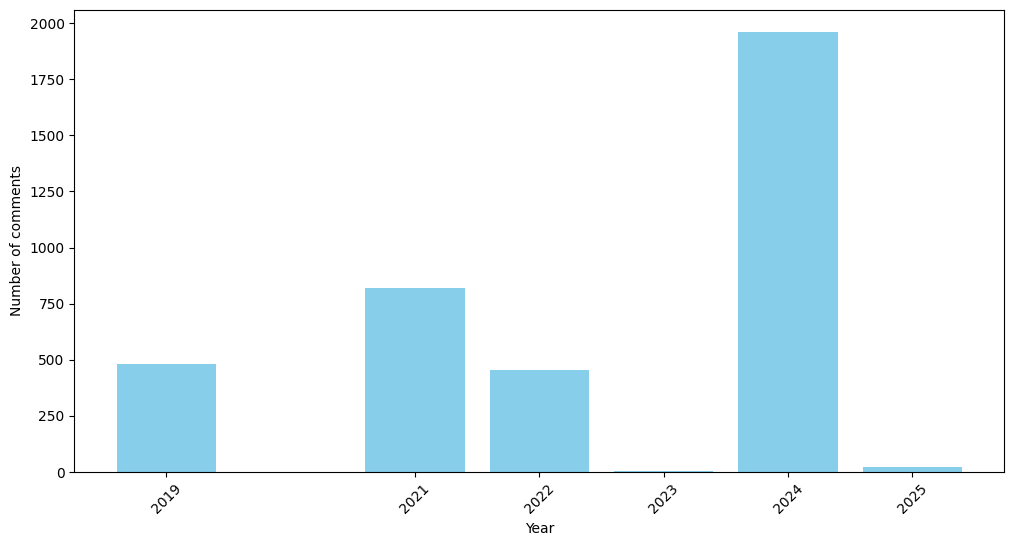

In [ ]:
import praw
import logging
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
import pandas as pd
from datetime import datetime

# Configurar logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

def fetch_comments(submission):
    comments = []
    try:
        submission.comments.replace_more(limit=0)  # Eliminar comentarios "continuación"
        comments_list = submission.comments.list()

        if comments_list is None or not hasattr(comments_list, '__iter__'):
            logging.warning(f"No se obtuvieron comentarios o la respuesta no es iterable para la publicación: {submission.title}")
            return comments

        for comment in comments_list:
            comments.append({
                'body': comment.body,
                'created_utc': datetime.utcfromtimestamp(comment.created_utc).year
            })
        logging.info(f"Comentarios obtenidos de la publicación '{submission.title}': {len(comments)} comentarios.")
    except Exception as e:
        logging.error(f"Error al obtener comentarios para la publicación '{submission.title}': {e}")
    return comments

def generate_wordcloud(text):
    if not text:
        logging.warning("No hay texto para generar la WordCloud.")
        return

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def analyze_sentiments(comments):
    if not comments:
        logging.warning("No hay comentarios para analizar.")
        return

    sentiments = {'positive': 0, 'neutral': 0, 'negative': 0}
    for comment in comments:
        analysis = TextBlob(comment['body']).sentiment
        if analysis.polarity > 0:
            sentiments['positive'] += 1
        elif analysis.polarity == 0:
            sentiments['neutral'] += 1
        else:
            sentiments['negative'] += 1

    logging.info(f"Análisis de sentimientos: {sentiments}")
    return sentiments

def plot_sentiment_analysis(sentiments):
    if not sentiments:
        logging.warning("No hay datos de sentimientos para graficar.")
        return

    labels = list(sentiments.keys())
    sizes = list(sentiments.values())
    colors = ['#ff9999','#66b3ff','#99ff99']

    plt.figure(figsize=(8, 6))
    plt.bar(labels, sizes, color=colors)
    plt.xlabel('Sentimiento')
    plt.ylabel('Número de Comentarios')
    plt.title('Análisis de Sentimientos de Comentarios')
    plt.show()

def plot_comments_by_year(comments):
    if not comments:
        logging.warning("No hay comentarios para graficar por año.")
        return

    # Convertir la lista de comentarios en un DataFrame de pandas
    df = pd.DataFrame(comments)

    # Verificar los datos
    print("Datos de los comentarios:")
    print(df.head())

    # Contar el número de comentarios por año
    yearly_counts = df['created_utc'].value_counts().sort_index()

    # Verificar el conteo por año
    print("Conteo de comentarios por año:")
    print(yearly_counts)

    plt.figure(figsize=(12, 6))
    plt.bar(yearly_counts.index, yearly_counts.values, color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Number of comments')
    plt.xticks(yearly_counts.index, rotation=45)
    plt.show()

def main():
    logging.info("Iniciando el script para obtener publicaciones y comentarios")

    # Conectar a Reddit
    reddit = praw.Reddit(
        client_id='B6uafLL8_mKqxaqhLYiw-w',
        client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
        user_agent='Carrot_analysis'
    )
    logging.info("Conectado a Reddit exitosamente")

    subreddit = reddit.subreddit("cooking")
    logging.info(f"Accediendo al subreddit: {subreddit.display_name}")

    publicaciones_procesadas = 0
    all_comments = []

    for submission in subreddit.search("carrot", sort="relevance", limit=10):  # Aumentar el límite si es necesario
        publicaciones_procesadas += 1
        logging.info(f"Procesando publicación {publicaciones_procesadas}: {submission.title}")

        # Obtener comentarios de la publicación
        comments = fetch_comments(submission)
        all_comments.extend(comments)

    # Verificar los años extraídos
    years = [comment['created_utc'] for comment in all_comments]
    print(f"Años extraídos: {years}")

    # Unir todos los comentarios en un solo texto
    text = " ".join(comment['body'] for comment in all_comments)

    if text:
        logging.info("Generando WordCloud...")
        generate_wordcloud(text)
    else:
        logging.info("No se encontraron comentarios para generar la WordCloud.")

    # Realizar análisis de sentimientos
    sentiments = analyze_sentiments(all_comments)

    # Graficar el análisis de sentimientos
    plot_sentiment_analysis(sentiments)

    # Graficar el número de comentarios por año
    plot_comments_by_year(all_comments)

    logging.info("Script finalizado correctamente")

if __name__ == "__main__":
    main()




In [ ]:
import asyncpraw
import asyncio

async def main():
    async with asyncpraw.Reddit(
        client_id='B6uafLL8_mKqxaqhLYiw-w',
        client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
        user_agent='Carrot_analysis'
    ) as reddit:  # Usar un contexto para manejar la sesión
        try:
            # Elegir el subreddit para buscar (por ejemplo, 'cooking')
            subreddit = await reddit.subreddit("cooking")

            # Buscar publicaciones que mencionen "zanahoria"
            async for submission in subreddit.search("zanahoria", sort="relevance", limit=10):
                print(f"Título: {submission.title}")
                print(f"Autor: {submission.author}")
                print(f"Puntuación: {submission.score}")
                print(f"Texto: {submission.selftext}")
                print("\nComentarios:\n")

                # Obtener comentarios de cada publicación
                await submission.comments.replace_more(limit=0)
                for comment in submission.comments.list():
                    print(f"Comentario: {comment.body}")
                    print(f"Autor del comentario: {comment.author}")
                    print(f"Puntuación del comentario: {comment.score}")
                    print("-----")

            print("Extracción completada.")

        except Exception as e:
            print(f"Se produjo un error: {e}")

# Ejecutar la función asincrónica
await main()

Extracción completada.


In [ ]:
import asyncpraw
import asyncio
from wordcloud import WordCloud
import matplotlib.pyplot as plt

async def main():
    async with asyncpraw.Reddit(
        client_id='B6uafLL8_mKqxaqhLYiw-w',
        client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
        user_agent='Carrot_analysis'
    ) as reddit:
        subreddit = await reddit.subreddit("cooking")
        comentarios = []

        # Buscar publicaciones que mencionen "zanahoria"
        async for submission in subreddit.search("carrot", sort="relevance", limit=10):
            print(f"Encontrada publicación: {submission.title}")  # Imprimir título de la publicación
            try:
                await submission.comments.replace_more(limit=0)
                if submission.comments:  # Verificar si hay comentarios
                    for comment in submission.comments.list():
                        comentarios.append(comment.body)
                else:
                    print(f"La publicación '{submission.title}' no tiene comentarios.")
            except Exception as e:
                print(f"Error al procesar la publicación '{submission.title}': {e}")

        # Verificar si se han extraído comentarios
        if not comentarios:
            print("No se encontraron comentarios para la búsqueda.")
            return  # Salir de la función si no hay comentarios

        # Generar la nube de palabras
        texto_comentarios = ' '.join(comentarios)  # Unir todos los comentarios en un solo string
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_comentarios)

        # Mostrar la nube de palabras
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')  # No mostrar ejes
        plt.show()

# Ejecutar la función asincrónica
await main()

/usr/lib/python3.10/selectors.py:367: RuntimeWarning: coroutine 'main' was never awaited
  key = super().unregister(fileobj)


Encontrada publicación: Please stop telling me to sauté onions before carrots in recipes.
Error al procesar la publicación 'Please stop telling me to sauté onions before carrots in recipes.': 'NoneType' object is not iterable
Encontrada publicación: Adding finely grated carrots to a minced meat in bolognese sauce taste good, reduce meat usage and adds vitamins.
Error al procesar la publicación 'Adding finely grated carrots to a minced meat in bolognese sauce taste good, reduce meat usage and adds vitamins.': 'NoneType' object is not iterable
Encontrada publicación: Hot tip: Dont put purple carrots into chicken noodle soup
Error al procesar la publicación 'Hot tip: Dont put purple carrots into chicken noodle soup': 'NoneType' object is not iterable
Encontrada publicación: My wife purchased the largest bag of carrots imaginable. What kind of side dish can I make that'll go with standard, Midwest style meatloaf?
Error al procesar la publicación 'My wife purchased the largest bag of carrot

In [ ]:
import asyncpraw
import asyncio
from wordcloud import WordCloud
import matplotlib.pyplot as plt

async def main():
    async with asyncpraw.Reddit(
        client_id='B6uafLL8_mKqxaqhLYiw-w',
        client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
        user_agent='Carrot_analysis'
    ) as reddit:
        subreddit = await reddit.subreddit("cooking")
        comentarios = []

        # Buscar publicaciones que mencionen "carrot"
        async for submission in subreddit.search("carrot", sort="relevance", limit=20):  # Aumentar el límite
            print(f"Encontrada publicación: {submission.title}")  # Imprimir título de la publicación
            try:
                await submission.comments.replace_more(limit=0)

                # Verificar si hay comentarios
                if hasattr(submission, 'comments') and submission.comments:
                    for comment in submission.comments.list():
                        comentarios.append(comment.body)
                        print(f"Comentario: {comment.body}")  # Imprimir cada comentario
                else:
                    print(f"La publicación '{submission.title}' no tiene comentarios o no se pudo acceder a ellos.")
            except Exception as e:
                print(f"Error al procesar la publicación '{submission.title}': {e}")

        # Verificar si se han extraído comentarios
        if not comentarios:
            print("No se encontraron comentarios para la búsqueda.")
            return  # Salir de la función si no hay comentarios

        # Generar la nube de palabras
        texto_comentarios = ' '.join(comentarios)  # Unir todos los comentarios en un solo string
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_comentarios)

        # Mostrar la nube de palabras
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')  # No mostrar ejes
        plt.show()

# Ejecutar la función asincrónica
await main()

Encontrada publicación: Please stop telling me to sauté onions before carrots in recipes.
Error al procesar la publicación 'Please stop telling me to sauté onions before carrots in recipes.': 'NoneType' object is not iterable
Encontrada publicación: Best dish for bland carrots?
Error al procesar la publicación 'Best dish for bland carrots?': 'NoneType' object is not iterable
Encontrada publicación: Best carrot dish?
Error al procesar la publicación 'Best carrot dish?': 'NoneType' object is not iterable
Encontrada publicación: Carrot is the perfect vegetable.
Error al procesar la publicación 'Carrot is the perfect vegetable.': 'NoneType' object is not iterable
Encontrada publicación: “Carrot trick” for homemade Italian Sauce.
Error al procesar la publicación '“Carrot trick” for homemade Italian Sauce.': 'NoneType' object is not iterable
Encontrada publicación: Hot tip: Dont put purple carrots into chicken noodle soup
Error al procesar la publicación 'Hot tip: Dont put purple carrots int

In [ ]:
import asyncpraw
import asyncio
import logging
import nest_asyncio

# Aplicar nest_asyncio para permitir usar asyncio en Google Colab
nest_asyncio.apply()

# Configurar logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)  # Asegurarse de que todos los niveles de logging se muestran

async def main():
    logging.info("Iniciando el script de prueba de conexión")

    # Conectar a Reddit
    try:
        async with asyncpraw.Reddit(
            client_id='B6uafLL8_mKqxaqhLYiw-w',
            client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
            user_agent='Carrot_analysis'
        ) as reddit:
            logging.info("Conectado a Reddit exitosamente")
    except Exception as e:
        logging.error(f"Error al conectar a Reddit: {e}")
        return

    logging.info("Script finalizado correctamente")

# Ejecutar la función main usando el bucle de eventos existente
await main()

INFO:root:Iniciando el script de prueba de conexión
INFO:root:Conectado a Reddit exitosamente
INFO:root:Script finalizado correctamente


In [ ]:
import asyncpraw
import asyncio
import logging
import nest_asyncio

# Aplicar nest_asyncio para permitir usar asyncio en Google Colab
nest_asyncio.apply()

# Configurar logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)  # Asegurarse de que todos los niveles de logging se muestran

async def fetch_comments(submission):
    comments = []
    try:
        await submission.comments.replace_more(limit=0)  # Eliminar comentarios "continuación"
        comments_list = submission.comments.list()

        if comments_list is None:
            logging.warning(f"No se obtuvieron comentarios (None) para la publicación: {submission.title}")
            return comments  # Devuelve una lista vacía si no hay comentarios

        for comment in comments_list:
            comments.append(comment.body)
        logging.info(f"Comentarios obtenidos de la publicación '{submission.title}': {len(comments)} comentarios.")
    except Exception as e:
        logging.error(f"Error al obtener comentarios para la publicación '{submission.title}': {e}")
    return comments

async def main():
    logging.info("Iniciando el script para obtener publicaciones y comentarios")

    # Conectar a Reddit
    async with asyncpraw.Reddit(
        client_id='B6uafLL8_mKqxaqhLYiw-w',
        client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
        user_agent='Carrot_analysis'
    ) as reddit:
        logging.info("Conectado a Reddit exitosamente")

        subreddit = await reddit.subreddit("cooking")
        logging.info(f"Accediendo al subreddit: {subreddit.display_name}")

        publicaciones_procesadas = 0
        async for submission in subreddit.search("carrot", sort="relevance", limit=5):
            publicaciones_procesadas += 1
            logging.info(f"Procesando publicación {publicaciones_procesadas}: {submission.title}")

            # Obtener comentarios de la publicación
            comments = await fetch_comments(submission)
            if comments:
                logging.info(f"Primeros 5 comentarios de '{submission.title}': {comments[:5]}")

    logging.info("Script finalizado correctamente")

# Ejecutar la función main usando el bucle de eventos existente
await main()

INFO:root:Iniciando el script para obtener publicaciones y comentarios
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): pypi.org:443
DEBUG:urllib3.connectionpool:https://pypi.org:443 "GET /pypi/asyncpraw/json HTTP/1.1" 200 7784
INFO:root:Conectado a Reddit exitosamente
INFO:root:Accediendo al subreddit: cooking
DEBUG:asyncprawcore:Fetching: GET https://oauth.reddit.com/r/cooking/search/ at 1725214360.4996345
DEBUG:asyncprawcore:Data: None
DEBUG:asyncprawcore:Params: {'limit': '5',
 'q': 'carrot',
 'raw_json': '1',
 'restrict_sr': 'true',
 'sort': 'relevance',
 'syntax': 'lucene',
 't': 'all'}
DEBUG:asyncprawcore:Response: 200 (3579 bytes) (rst-439:rem-999.0:used-1 ratelimit) at 1725214360.856602
INFO:root:Procesando publicación 1: Please stop telling me to sauté onions before carrots in recipes.
ERROR:root:Error al obtener comentarios para la publicación 'Please stop telling me to sauté onions before carrots in recipes.': 'NoneType' object is not iterable
INFO:root:Proce

In [ ]:
import praw
import logging

# Configurar logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

def fetch_comments(submission):
    comments = []
    try:
        submission.comments.replace_more(limit=0)  # Eliminar comentarios "continuación"
        comments_list = submission.comments.list()

        # Agregar depuración para la estructura de datos
        logging.debug(f"Estructura de datos de comments_list: {type(comments_list)}")
        logging.debug(f"Contenido de comments_list: {comments_list}")

        if comments_list is None:
            logging.warning(f"No se obtuvieron comentarios (None) para la publicación: {submission.title}")
            return comments  # Devuelve una lista vacía si no hay comentarios

        if not hasattr(comments_list, '__iter__'):
            logging.error(f"La respuesta de comentarios no es iterable para la publicación: {submission.title}")
            return comments

        for comment in comments_list:
            comments.append(comment.body)
        logging.info(f"Comentarios obtenidos de la publicación '{submission.title}': {len(comments)} comentarios.")
    except Exception as e:
        logging.error(f"Error al obtener comentarios para la publicación '{submission.title}': {e}")
    return comments

def main():
    logging.info("Iniciando el script para obtener publicaciones y comentarios")

    # Conectar a Reddit
    reddit = praw.Reddit(
        client_id='B6uafLL8_mKqxaqhLYiw-w',
        client_secret='An-Qph6_mKlyg-Xvmta4OcjqfBmiZQ',
        user_agent='Carrot_analysis'
    )
    logging.info("Conectado a Reddit exitosamente")

    subreddit = reddit.subreddit("cooking")
    logging.info(f"Accediendo al subreddit: {subreddit.display_name}")

    publicaciones_procesadas = 0
    for submission in subreddit.search("carrot", sort="relevance", limit=5):
        publicaciones_procesadas += 1
        logging.info(f"Procesando publicación {publicaciones_procesadas}: {submission.title}")

        # Obtener comentarios de la publicación
        comments = fetch_comments(submission)
        if comments:
            logging.info(f"Primeros 5 comentarios de '{submission.title}': {comments[:5]}")
        else:
            logging.info(f"No se encontraron comentarios para la publicación '{submission.title}'")

    logging.info("Script finalizado correctamente")

if __name__ == "__main__":
    main()

INFO:root:Iniciando el script para obtener publicaciones y comentarios
INFO:root:Conectado a Reddit exitosamente
INFO:root:Accediendo al subreddit: cooking
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

DEBUG:prawcore:Fetching: GET https://oauth.reddit.com/r/cooking/search/ at 1725215157.0493422
DEBUG:prawcore:Data: None
DEBUG:prawcore:Params: {'limit': 5,
 'q': 'carrot',
 'raw_json': 1,
 'restrict_sr': True,
 'sort': 'relevance',
 'syntax': 'lucene',
 't': 'all'}
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): www.reddit.com:443
DEBUG:urllib3.connectionpool:https://www.reddit.com:443 "POST /api/v1/access_token HTTP/1.1" 200 654
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): oauth.reddit.com:443
DEBUG:urllib3.connectionpool:https://oauth.reddit.com:443 "GET /r/cooking/search/?q=carr

In [ ]:
pip install --upgrade python-facebook-api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.7 MB/s eta 0:00:00


In [ ]:
from pyfacebook import GraphAPI
api = GraphAPI(access_token="EAA2b8yaURV0BOxU8n49HGg4nYfXQokWYjwWFRxvew6zSuRwouGP7nYCxllw3bjE9v0yYOxWGde0ZCRCidB7rxzuDo3ZBKYfqZB38gXmZCA2ZB9XKfIc239NriAC6P2dmWm5ZAU7BKdCSbtgPAEZAHSRrg07quW8pEWWxBkqrPThH5FsJm9keWjJVmi43ZAbADShFmoFGvwlwmQ4kGvTKK8cJPWpBMmmUPfccSgbm5ZAEvxlstdtfpIBZCNGCkLCDQT")

In [ ]:
from pyfacebook import GraphAPI
api = GraphAPI(app_id="3830643323848029", app_secret="4afd544a6ed44498e9c049eb718e481a", application_only_auth=True)

In [ ]:
pip install Facebook-sdk

In [ ]:
import facebook

graph = facebook.GraphAPI(access_token="EAA2b8yaURV0BOxU8n49HGg4nYfXQokWYjwWFRxvew6zSuRwouGP7nYCxllw3bjE9v0yYOxWGde0ZCRCidB7rxzuDo3ZBKYfqZB38gXmZCA2ZB9XKfIc239NriAC6P2dmWm5ZAU7BKdCSbtgPAEZAHSRrg07quW8pEWWxBkqrPThH5FsJm9keWjJVmi43ZAbADShFmoFGvwlwmQ4kGvTKK8cJPWpBMmmUPfccSgbm5ZAEvxlstdtfpIBZCNGCkLCDQT")

In [ ]:
# Get the message from a post.
post = graph.get_object(id='post_id', fields='message')
print(post['message'])

In [ ]:
# Set up our access token
access_token = 'EAA2b8yaURV0BOxU8n49HGg4nYfXQokWYjwWFRxvew6zSuRwouGP7nYCxllw3bjE9v0yYOxWGde0ZCRCidB7rxzuDo3ZBKYfqZB38gXmZCA2ZB9XKfIc239NriAC6P2dmWm5ZAU7BKdCSbtgPAEZAHSRrg07quW8pEWWxBkqrPThH5FsJm9keWjJVmi43ZAbADShFmoFGvwlwmQ4kGvTKK8cJPWpBMmmUPfccSgbm5ZAEvxlstdtfpIBZCNGCkLCDQT'

# Authenticate with the Facebook API
graph = facebook.GraphAPI(access_token)

# Get the user's feed
feed = graph.get_object('https://www.facebook.com/agricultureandfarmingkerala')

# Print the message of each post
for post in feed['data']:
    if 'message' in post:
        print(post['message'])

NameError: name 'facebook' is not defined

In [ ]:
# Tu token de acceso generado
access_token = '3830643323848029|xey4NbkhMZOrw5kv6y9Hr7my05A'

# Autenticación con la API de Facebook
graph = facebook.GraphAPI(access_token)

# Accede al feed de una página pública, usando el ID o nombre de usuario de la página
page_id = 'https://www.facebook.com/agricultureandfarmingkerala'
# Obtener las publicaciones
feed = graph.get_object(f'{page_id}/posts')

# Imprimir el mensaje de cada publicación
for post in feed['data']:
    if 'message' in post:
        print(post['message'])


GraphAPIError: (#100) Object does not exist, cannot be loaded due to missing permission or reviewable feature, or does not support this operation. This endpoint requires the 'pages_read_engagement' permission or the 'Page Public Content Access' feature or the 'Page Public Metadata Access' feature. Refer to https://developers.facebook.com/docs/apps/review/login-permissions#manage-pages, https://developers.facebook.com/docs/apps/review/feature#reference-PAGES_ACCESS and https://developers.facebook.com/docs/apps/review/feature#page-public-metadata-access for details.

In [ ]:
import requests
from bs4 import BeautifulSoup

# URL de la página que quieres raspar
url = 'https://www.facebook.com/agricultureandfarmingkerala/search?q=carrot'

# Hacer una solicitud a la página web
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Buscar y extraer información relevante
for post in soup.find_all('div', class_='post-class'):
    message = post.get_text()
    if 'zanahoria' in message.lower():
        print(message)


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager

# Configura el WebDriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

# URL de la página que quieres raspar
url = 'https://www.facebook.com/agricultureandfarmingkerala/search?q=carrot'

# Abre la página
driver.get(url)

# Espera que el contenido cargue (ajusta el tiempo según sea necesario)
driver.implicitly_wait(10)

# Buscar publicaciones (ajusta el selector según la estructura de la página)
posts = driver.find_elements(By.CSS_SELECTOR, 'div._5pcr')

# Filtrar y mostrar publicaciones que contienen el término de búsqueda
search_term = 'carrot'
for post in posts:
    message = post.text
    if search_term.lower() in message.lower():
        print(message)

# Cerrar el navegador
driver.quit()


WebDriverException: Message: unknown error: cannot find Chrome binary
Stacktrace:
#0 0x5ad2e980a4e3 <unknown>
#1 0x5ad2e9539c76 <unknown>
#2 0x5ad2e9560757 <unknown>
#3 0x5ad2e955f029 <unknown>
#4 0x5ad2e959dccc <unknown>
#5 0x5ad2e959d47f <unknown>
#6 0x5ad2e9594de3 <unknown>
#7 0x5ad2e956a2dd <unknown>
#8 0x5ad2e956b34e <unknown>
#9 0x5ad2e97ca3e4 <unknown>
#10 0x5ad2e97ce3d7 <unknown>
#11 0x5ad2e97d8b20 <unknown>
#12 0x5ad2e97cf023 <unknown>
#13 0x5ad2e979d1aa <unknown>
#14 0x5ad2e97f36b8 <unknown>
#15 0x5ad2e97f3847 <unknown>
#16 0x5ad2e9803243 <unknown>
#17 0x7cdb3e741ac3 <unknown>


In [ ]:
# Define la página o entidad donde se buscará (puedes usar el ID de la página)
page_id = "https://www.facebook.com/agricultureandfarmingkerala"

# Realiza la búsqueda de publicaciones en la página que contengan el término "zanahoria" o "carrot"
posts = api.get_connection(object_id=page_id, connection="posts", fields="message", count=100)

# Filtra las publicaciones que mencionen 'zanahoria' o 'carrot'
zanahoria_posts = [post for post in posts if 'zanahoria' in post['message'].lower() or 'carrot' in post['message'].lower()]

# Muestra las publicaciones
for post in zanahoria_posts:
    print(post['message'])


FacebookError: FacebookError(code=100,message=(#100) Object does not exist, cannot be loaded due to missing permission or reviewable feature, or does not support this operation. This endpoint requires the 'pages_read_engagement' permission or the 'Page Public Content Access' feature or the 'Page Public Metadata Access' feature. Refer to https://developers.facebook.com/docs/apps/review/login-permissions#manage-pages, https://developers.facebook.com/docs/apps/review/feature#reference-PAGES_ACCESS and https://developers.facebook.com/docs/apps/review/feature#page-public-metadata-access for details.,type=OAuthException,fbtrace_id=AcfPcPtH3ESPPbyZAoYRhCd)

In [ ]:
from facebook_scraper import get_posts

# Extraer publicaciones sobre zanahorias de páginas públicas
for post in get_posts('zanahoria', pages=5):
    print(f"Post: {post['text']}\nFecha: {post['28/07/2023']}\n")